## Name: Isaac Coffie
## Plentify Internship Project
## Date: April 07 2020

In [ ]:
## Non-standard python libraries.. Kindly install the following libraries if you don't have it yet
"""
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install scikit-learn
!pip install xgboost
!pip install statsmodels
"""

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import xgboost as xgb

import warnings

In [ ]:
##register matplotlib datetime warnings
sns.set()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (100, 50),
         'axes.labelsize': 50,
         'axes.titlesize':70,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
plt.rcParams.update(params)
#plt.rcParams["figure.figsize"] = (50,20)  ##Define plotting size
#plt.rcParams["figure.figsize"] = (50,20)  ##Define plotting size

warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Datasets

In [ ]:
bulk_meter_df = pd.read_csv("./datasets/BulkMeterData.csv", encoding='iso-8859-1')
weather_df = pd.read_csv("./datasets/CapeTownWeather.csv", encoding='iso-8859-1')

### Data Exploration

In [ ]:
bulk_meter_df.head() ##peek through the first 5 data rows

DateTime  Power (kW)
0  2018-10-14 0:30     10.1980
1  2018-10-14 1:00      8.2462
2  2018-10-14 1:30     10.1980
3  2018-10-14 2:00     12.0000
4  2018-10-14 2:30      8.9443

In [ ]:
weather_df.head() ##peek through the first 5 data rows

Year  Month  Day  Hour  Minute  Temperature  Relative Humidity  \
0  2018     10   14     0       0        17.82                 65   
1  2018     10   14     1       0        17.86                 66   
2  2018     10   14     2       0        17.96                 66   
3  2018     10   14     3       0        17.72                 68   
4  2018     10   14     4       0        17.01                 71   

   Total Precipitation  Wind Speed  Wind Direction  
0                  0.0        8.89          148.24  
1                  0.0        6.61          150.64  
2                  0.0        3.67          168.69  
3                  0.0        9.75            4.24  
4                  0.0       20.36          351.87

In [ ]:
##Check the data types of both datasets

bulk_meter_df.info()


print("\n")

weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17472 entries, 0 to 17471
Data columns (total 2 columns):
DateTime      17472 non-null object
Power (kW)    17416 non-null float64
dtypes: float64(1), object(1)
memory usage: 273.1+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
Year                   8760 non-null int64
Month                  8760 non-null int64
Day                    8760 non-null int64
Hour                   8760 non-null int64
Minute                 8760 non-null int64
Temperature            8760 non-null float64
Relative Humidity      8760 non-null int64
Total Precipitation    8738 non-null float64
Wind Speed             8760 non-null float64
Wind Direction         8760 non-null float64
dtypes: float64(4), int64(6)
memory usage: 684.5 KB


In [ ]:
##Check missing values
print("Bulk Meter Load Missing Values")
print(bulk_meter_df.isnull().sum())

print("\n")
print("Weather Data Missing Values")
weather_df.isnull().sum()

Bulk Meter Load Missing Values
DateTime       0
Power (kW)    56
dtype: int64


Weather Data Missing Values


Year                    0
Month                   0
Day                     0
Hour                    0
Minute                  0
Temperature             0
Relative Humidity       0
Total Precipitation    22
Wind Speed              0
Wind Direction          0
dtype: int64

### Data preprocessing

In [ ]:
##Convert datetime to pandas datetime object
bulk_meter_df["DateTime"] = pd.to_datetime(bulk_meter_df["DateTime"])

##Since there are only 56 missing data, we can easily interpolate those missing values
bulk_meter_df = bulk_meter_df.interpolate(method='linear')
bulk_meter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17472 entries, 0 to 17471
Data columns (total 2 columns):
DateTime      17472 non-null datetime64[ns]
Power (kW)    17472 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 273.1 KB


In [ ]:
##Synchronizingg the Temperature Data.. 
#first upsample and fill in the NaNs using Spline interpolation which is better than a ploynomial interpolation

weather_date_range = pd.date_range(start="2018-10-14", end="2019-10-14", freq="H")

weather_temp_df = pd.DataFrame({"DateTime": weather_date_range[0:-1], "Temperature": weather_df.Temperature})

weather_temp_df_indexed = weather_temp_df.set_index("DateTime")

##Up sample the temperature data from 1 hour to 30 minutes and fill in missing values
upsampled_temperature_df = weather_temp_df_indexed.resample("30min").mean()
upsampled_temperature_df = upsampled_temperature_df.interpolate(method='spline', order=2)

upsampled_temperature_df.reset_index(inplace=True)
upsampled_temperature_df.head()

DateTime  Temperature
0 2018-10-14 00:00:00     17.82000
1 2018-10-14 00:30:00     17.73681
2 2018-10-14 01:00:00     17.86000
3 2018-10-14 01:30:00     17.50027
4 2018-10-14 02:00:00     17.96000

In [ ]:
##Let's now work on the weather dataframe, synching it with time

date_range = pd.date_range(start="2018-10-14", end="2019-10-13", freq="30min")

temp_df = pd.DataFrame({"DateTime": date_range[1:]})

temperature_df = pd.merge(temp_df, upsampled_temperature_df, on="DateTime" )
temperature_df.head(10)

DateTime  Temperature
0 2018-10-14 00:30:00    17.736810
1 2018-10-14 01:00:00    17.860000
2 2018-10-14 01:30:00    17.500270
3 2018-10-14 02:00:00    17.960000
4 2018-10-14 02:30:00    17.276532
5 2018-10-14 03:00:00    17.720000
6 2018-10-14 03:30:00    17.065597
7 2018-10-14 04:00:00    17.010000
8 2018-10-14 04:30:00    16.867464
9 2018-10-14 05:00:00    15.280000

In [ ]:
##Processing Test Data and include the forcasted temperature values
prediction_date_range = pd.date_range(start="2019-10-13", end="2019-10-14", freq="30min")

test_dataframe = pd.DataFrame({"DateTime": prediction_date_range[1:]})
test_dataframe = pd.merge(test_dataframe, upsampled_temperature_df, on="DateTime" )

##the forcasted weather data does not include data for October 14, 2019, so we add just the date since it's required in our test date range
extra_hours = pd.date_range(start="2019-10-13", end="2019-10-14", freq="30min")
extra_hours_df = pd.DataFrame({"DateTime": extra_hours[-2:], "Temperature": [None, None]})

##join the two dates together
test_df = pd.concat([test_dataframe, extra_hours_df], axis=0).reset_index(drop=True)
test_df = test_df.interpolate(method='spline', order=2)
test_df.head(10)

DateTime  Temperature
0 2019-10-13 00:30:00    13.907303
1 2019-10-13 01:00:00    15.080000
2 2019-10-13 01:30:00    13.525887
3 2019-10-13 02:00:00    14.950000
4 2019-10-13 02:30:00    13.502726
5 2019-10-13 03:00:00    14.760000
6 2019-10-13 03:30:00    13.837818
7 2019-10-13 04:00:00    14.670000
8 2019-10-13 04:30:00    14.531164
9 2019-10-13 05:00:00    14.590000

## Data Visualization

Text(0, 0.5, 'Bulk Meter Reading (kW)')

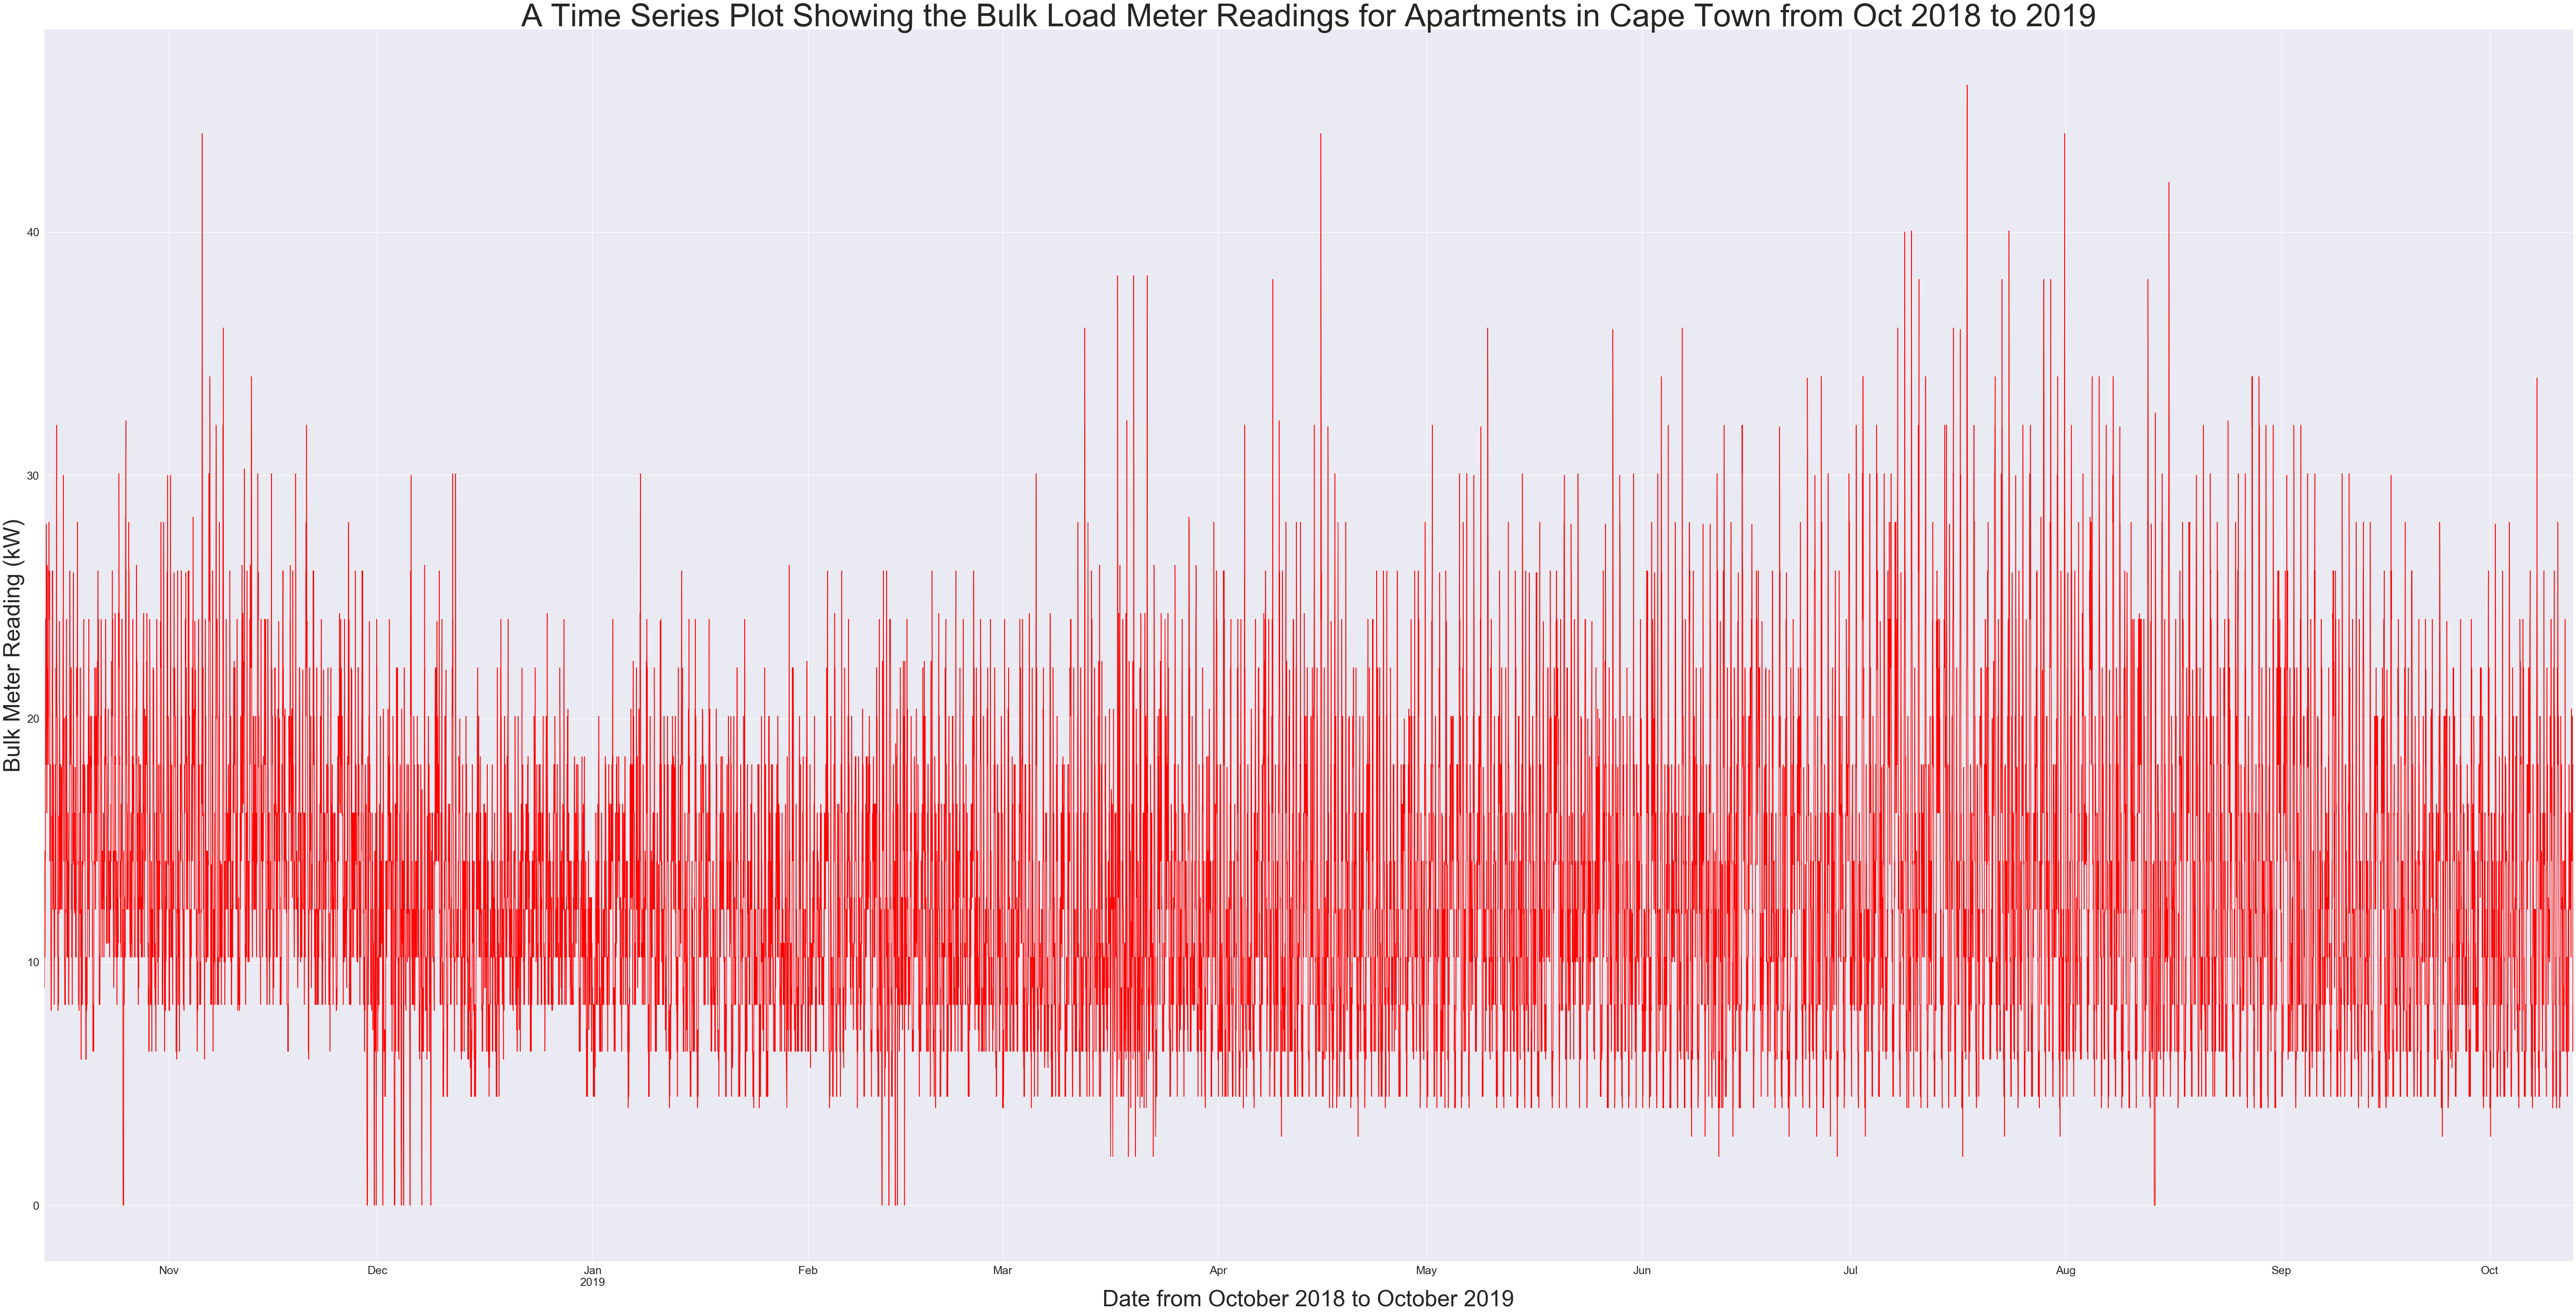

In [ ]:
## Visualize the bulk meter data
bulk_meter_indexed_df = bulk_meter_df.set_index('DateTime')
bulk_meter_indexed_df["Power (kW)"].plot(color='red')
plt.title("A Time Series Plot Showing the Bulk Load Meter Readings for Apartments in Cape Town from Oct 2018 to 2019")
plt.xlabel("Date from October 2018 to October 2019")
plt.ylabel("Bulk Meter Reading (kW)")

##### Try resampling the data into wekly and monthly to get a better view of the meter readings

Text(0, 0.5, 'Monthly Bulk Meter Reading (kW)')

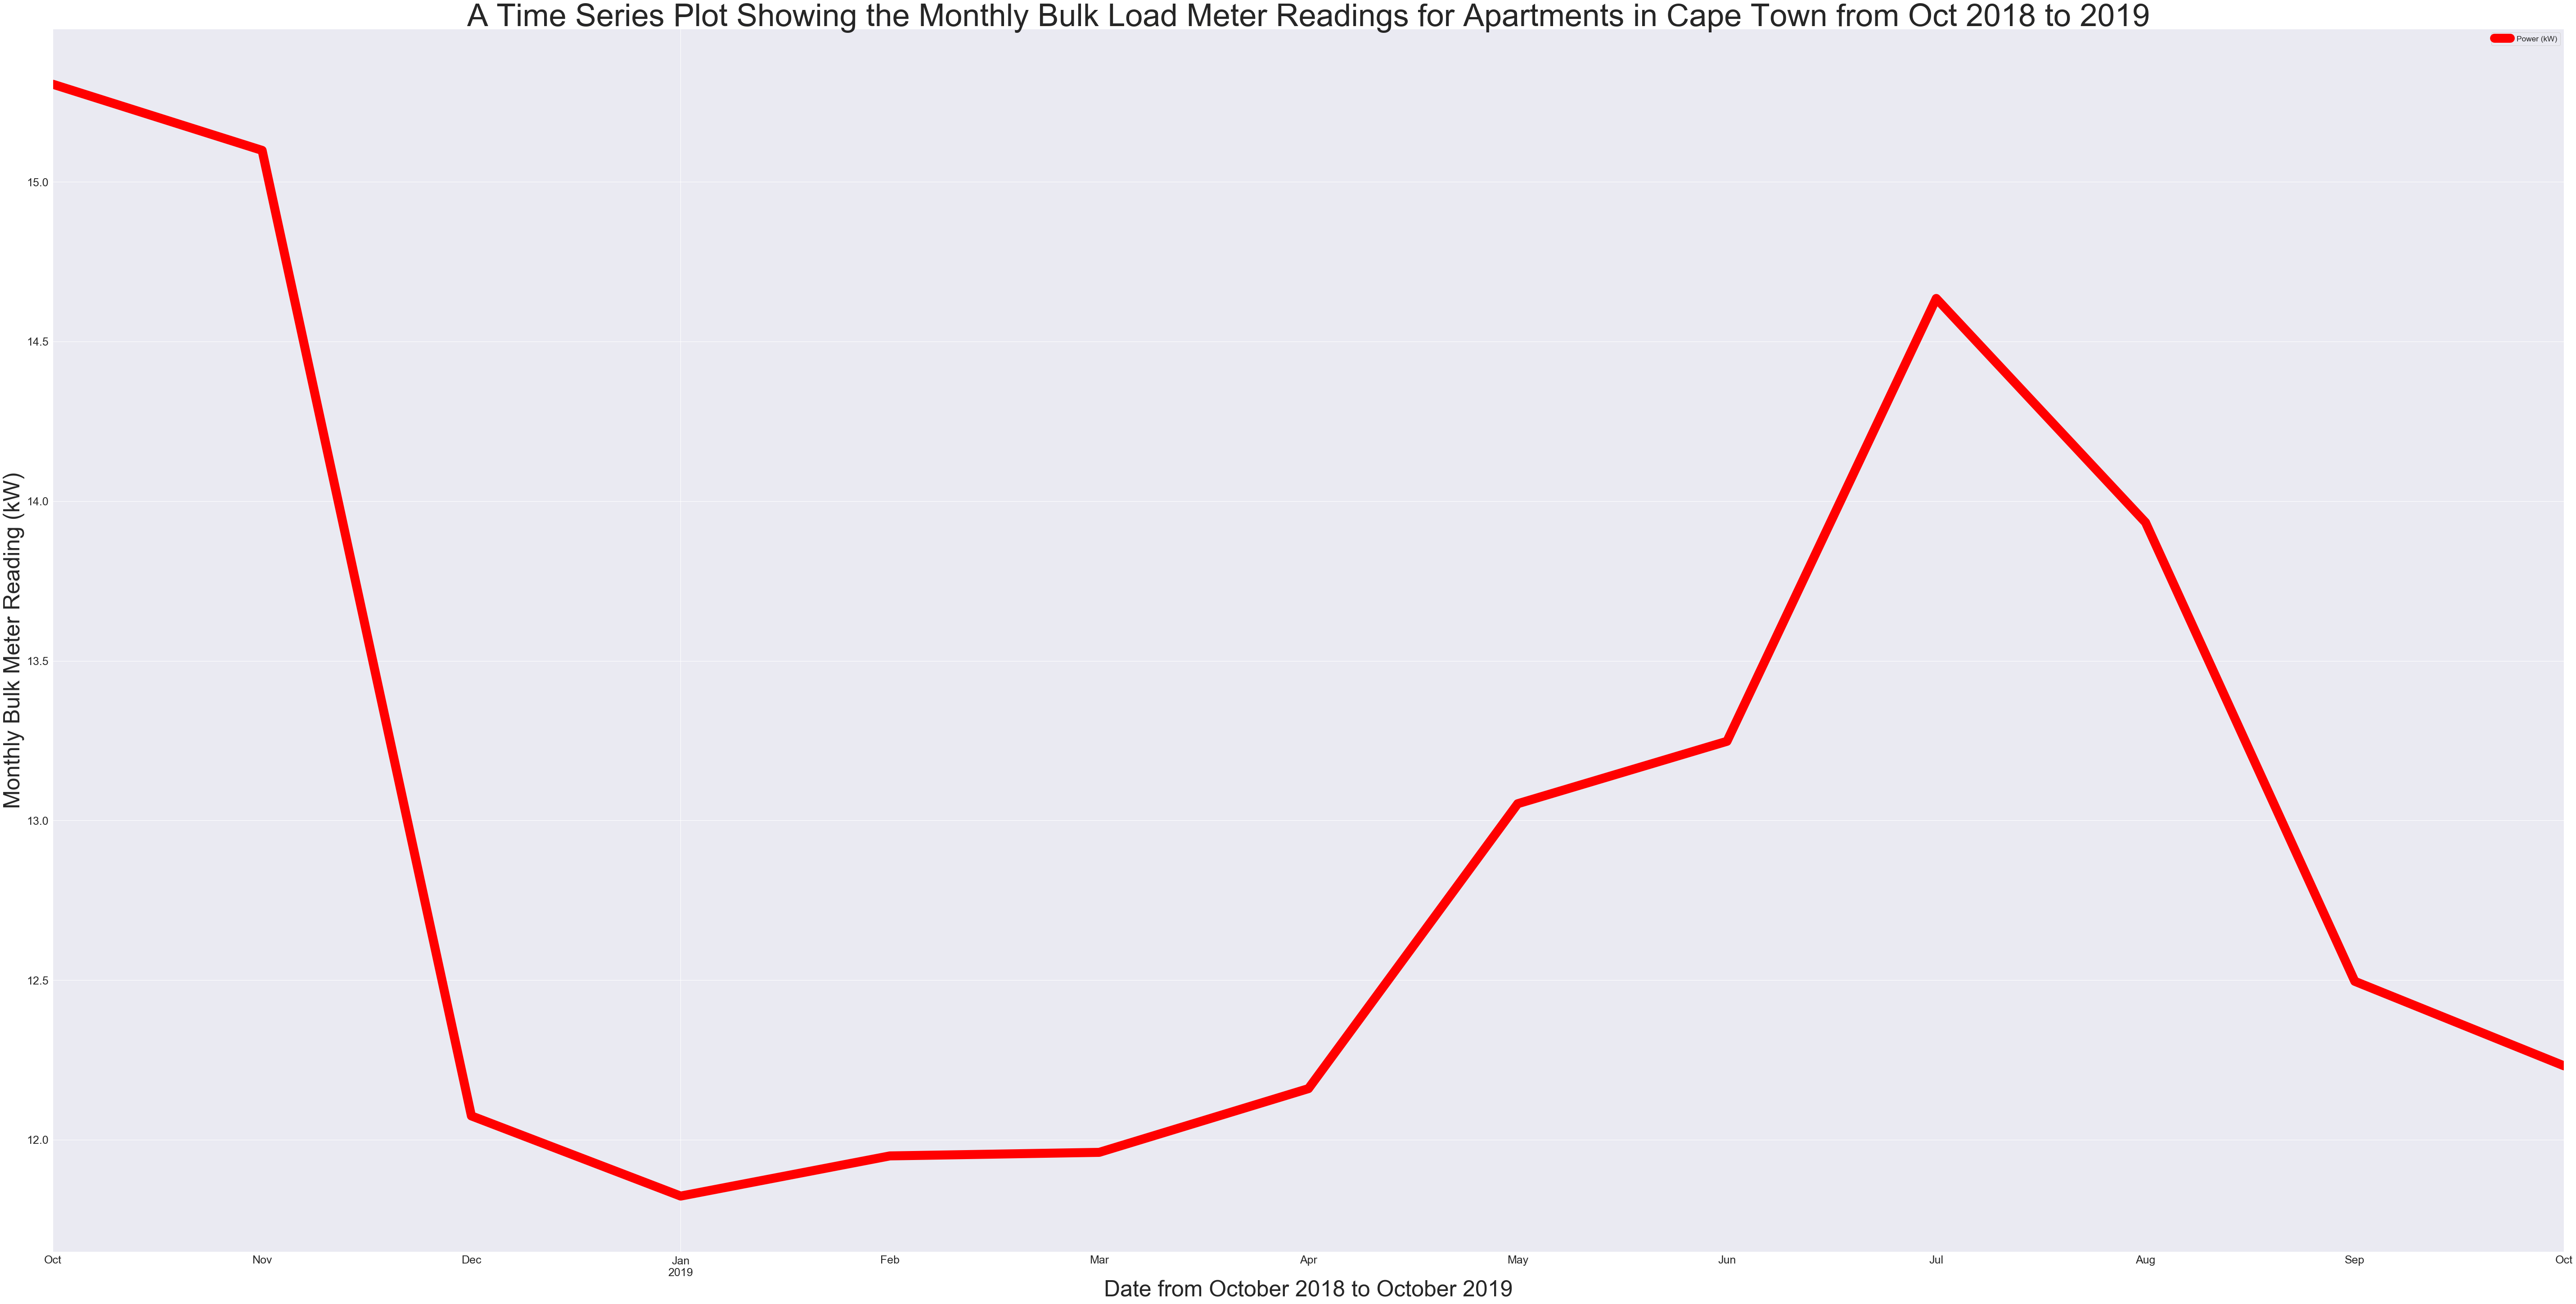

In [ ]:
##Monthly data
monthly_df = bulk_meter_indexed_df.resample('M').mean()
monthly_df.plot(color='red', linewidth=20)
plt.title("A Time Series Plot Showing the Monthly Bulk Load Meter Readings for Apartments in Cape Town from Oct 2018 to 2019")
plt.xlabel("Date from October 2018 to October 2019")
plt.ylabel("Monthly Bulk Meter Reading (kW)")

Text(0, 0.5, 'Weekly Bulk Meter Reading (kW)')

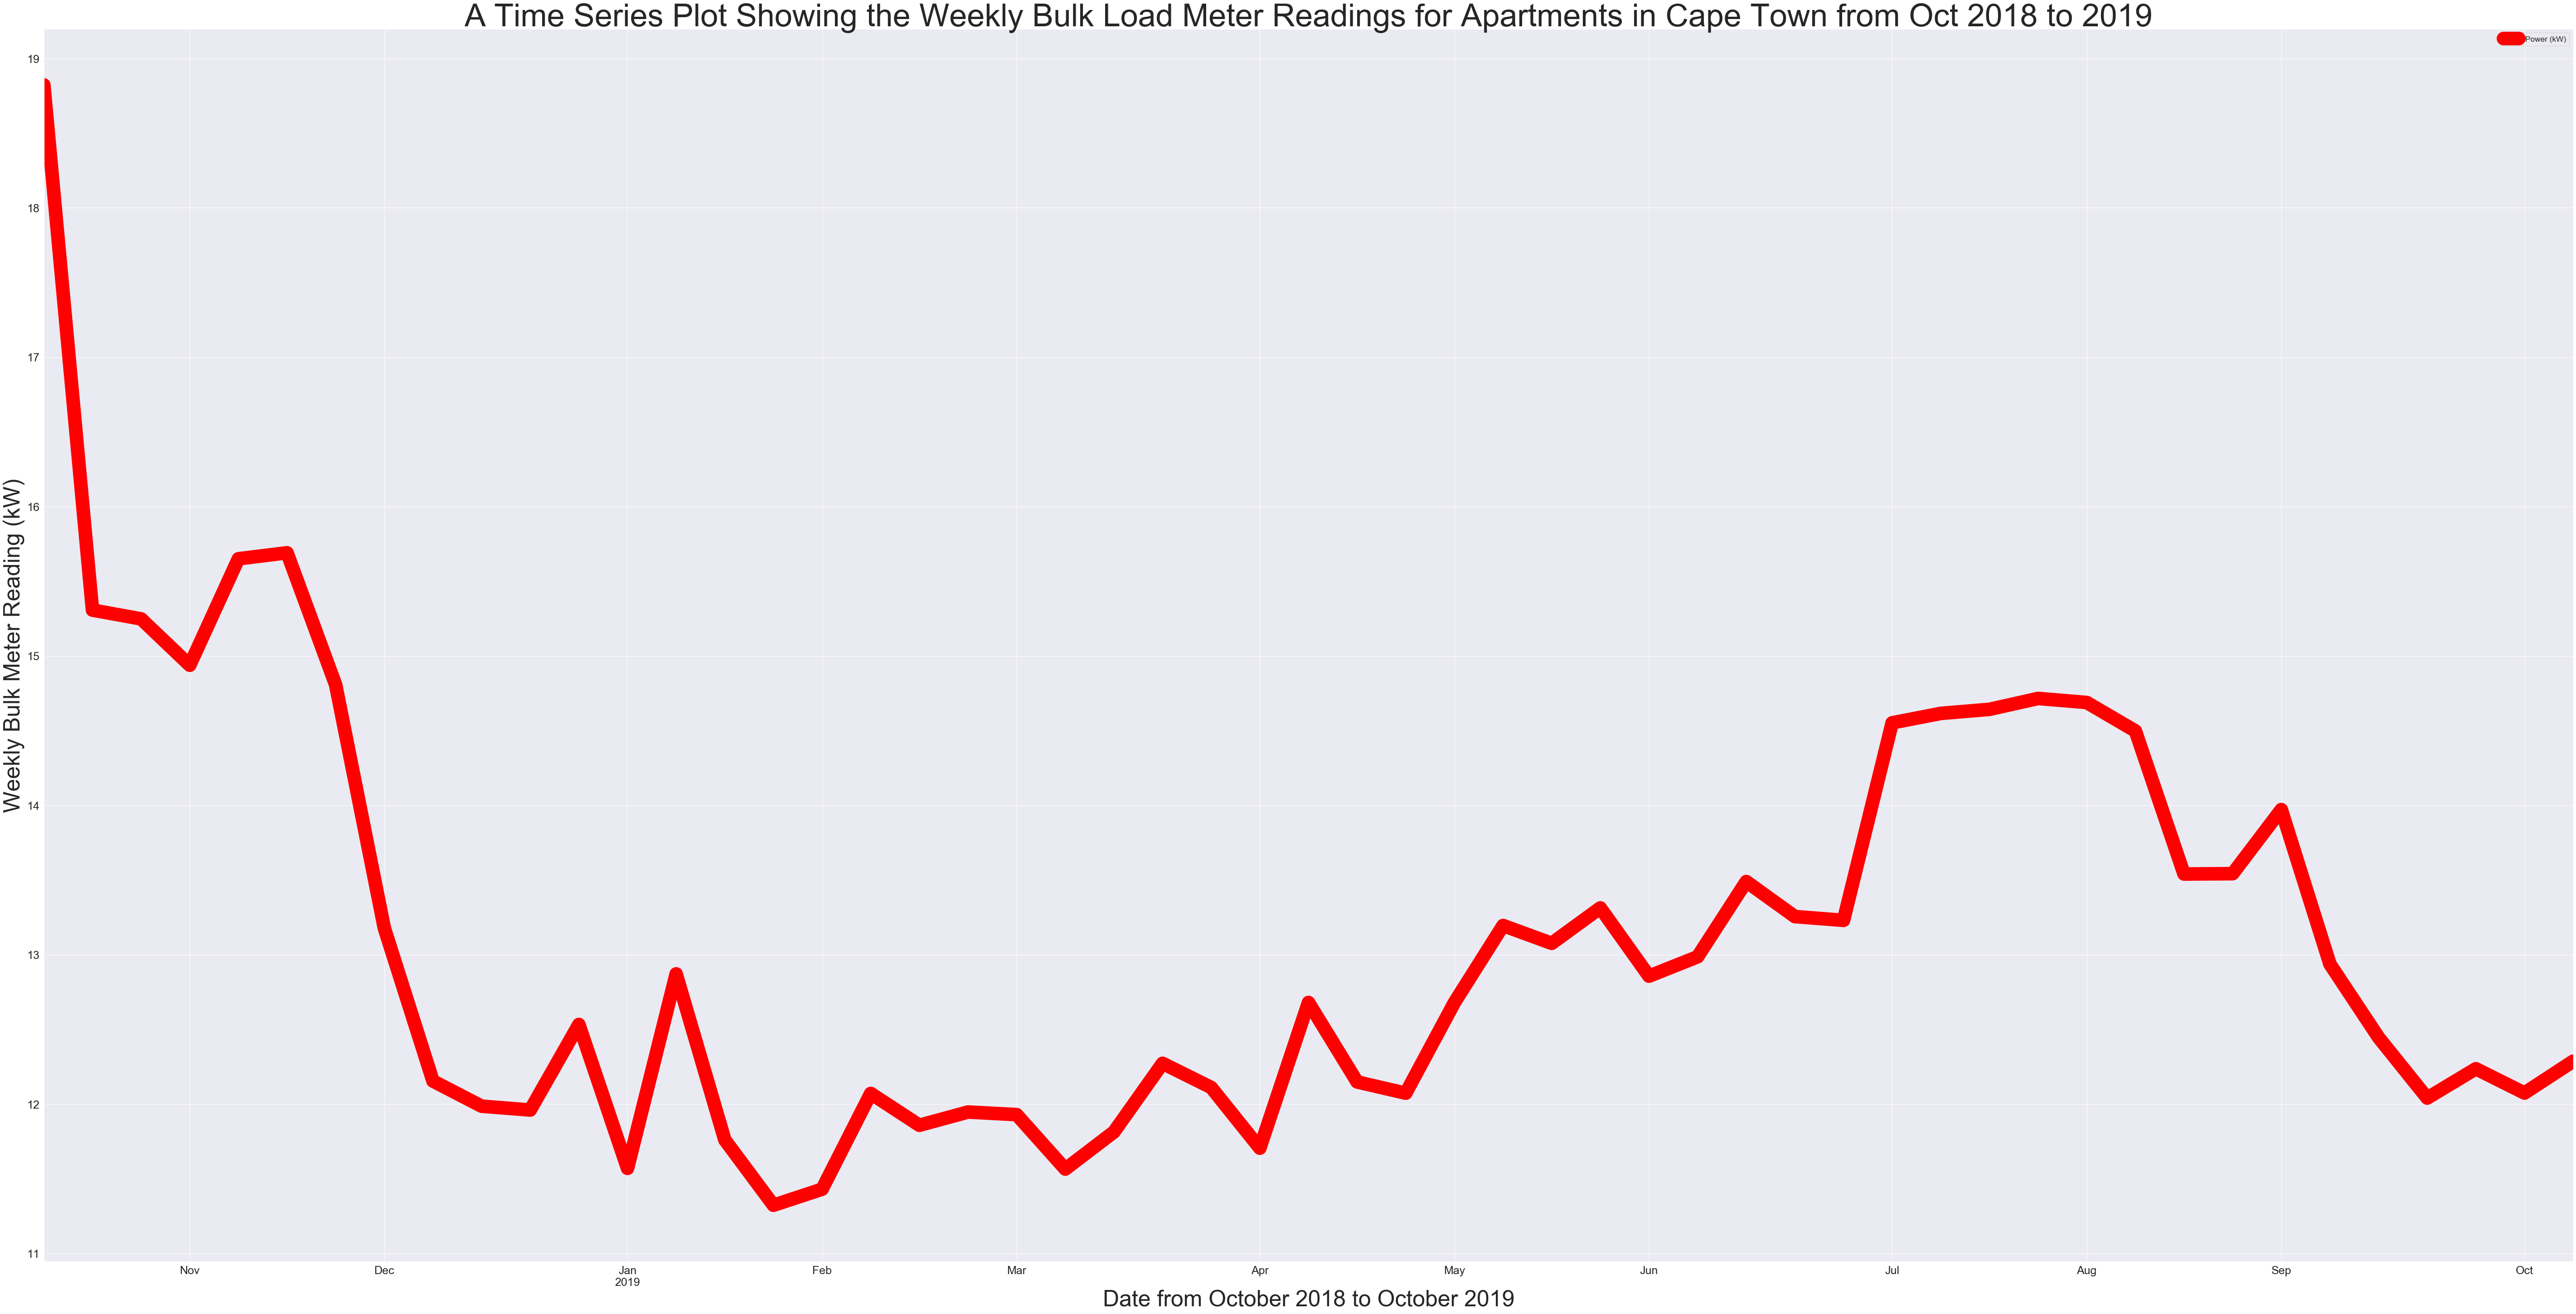

In [ ]:
##Try resampling on a weekly basis
weekly_df = bulk_meter_indexed_df.resample('W').mean()
weekly_df.plot(color='red', linewidth=30)
plt.title("A Time Series Plot Showing the Weekly Bulk Load Meter Readings for Apartments in Cape Town from Oct 2018 to 2019")
plt.xlabel("Date from October 2018 to October 2019")
plt.ylabel("Weekly Bulk Meter Reading (kW)")

Text(0, 0.5, 'Daily Bulk Meter Reading (kW)')

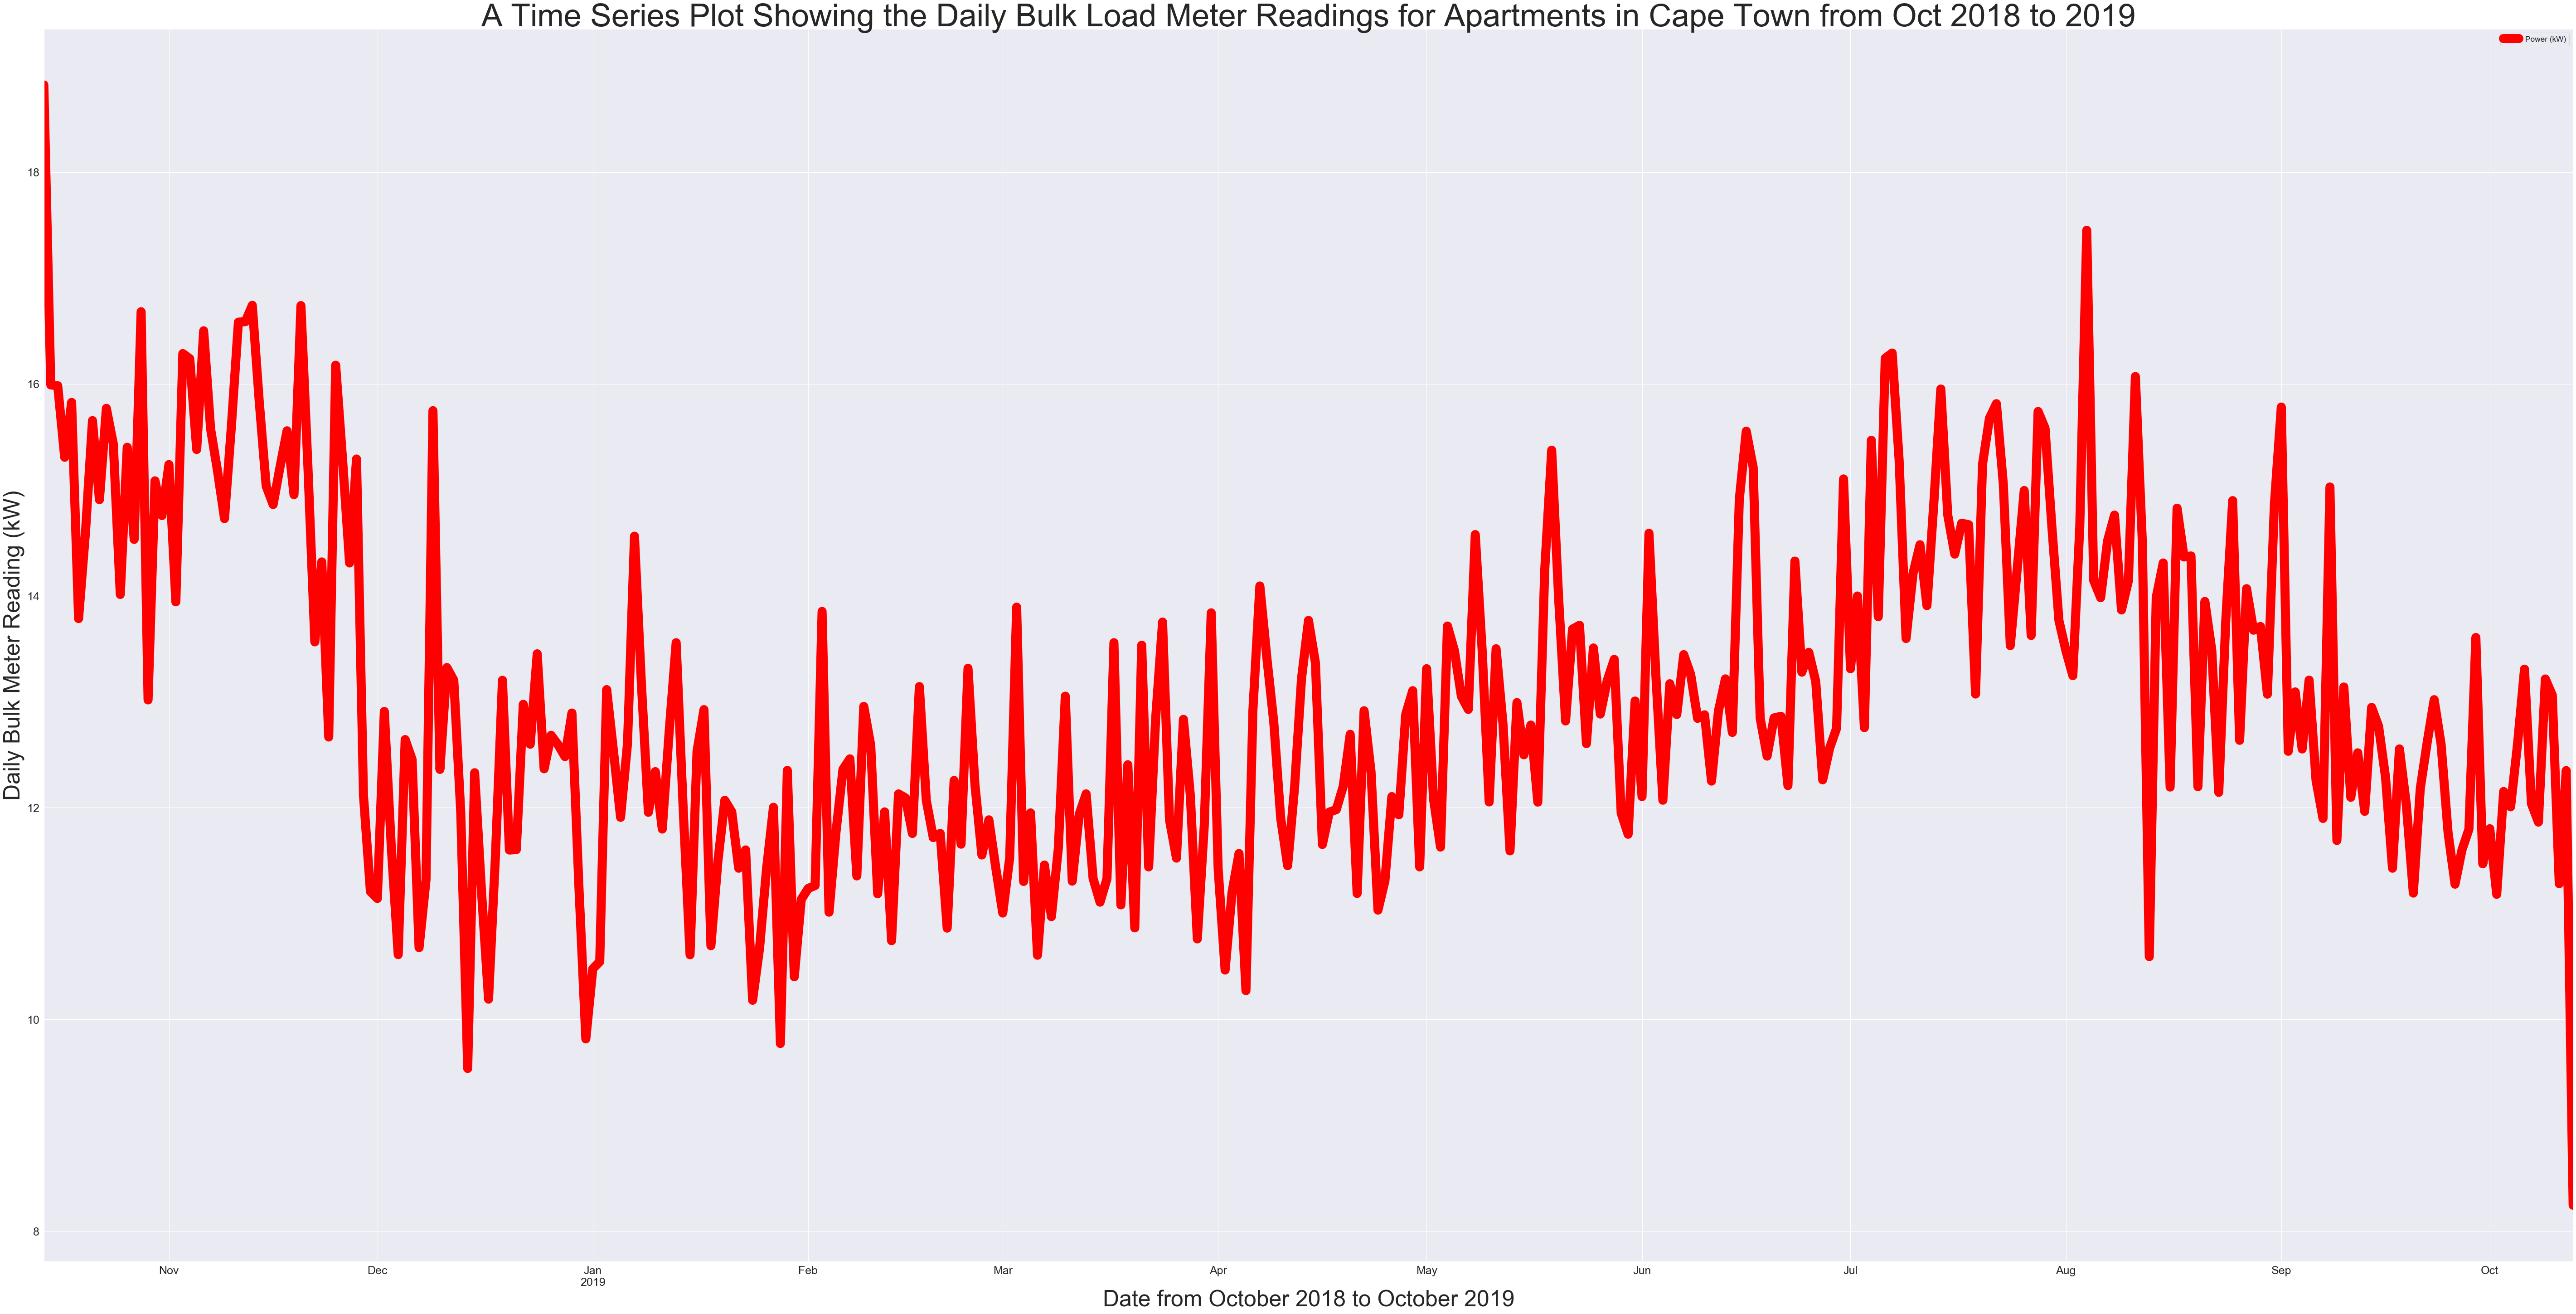

In [ ]:
## Try Daily
daily_df = bulk_meter_indexed_df.resample('D').mean()
daily_df.plot(color='red', linewidth=20)
plt.title("A Time Series Plot Showing the Daily Bulk Load Meter Readings for Apartments in Cape Town from Oct 2018 to 2019")
plt.xlabel("Date from October 2018 to October 2019")
plt.ylabel("Daily Bulk Meter Reading (kW)")

#### Temperature Values Data Visualization

Text(0, 0.5, 'Temperature Recordings (Celsius)')

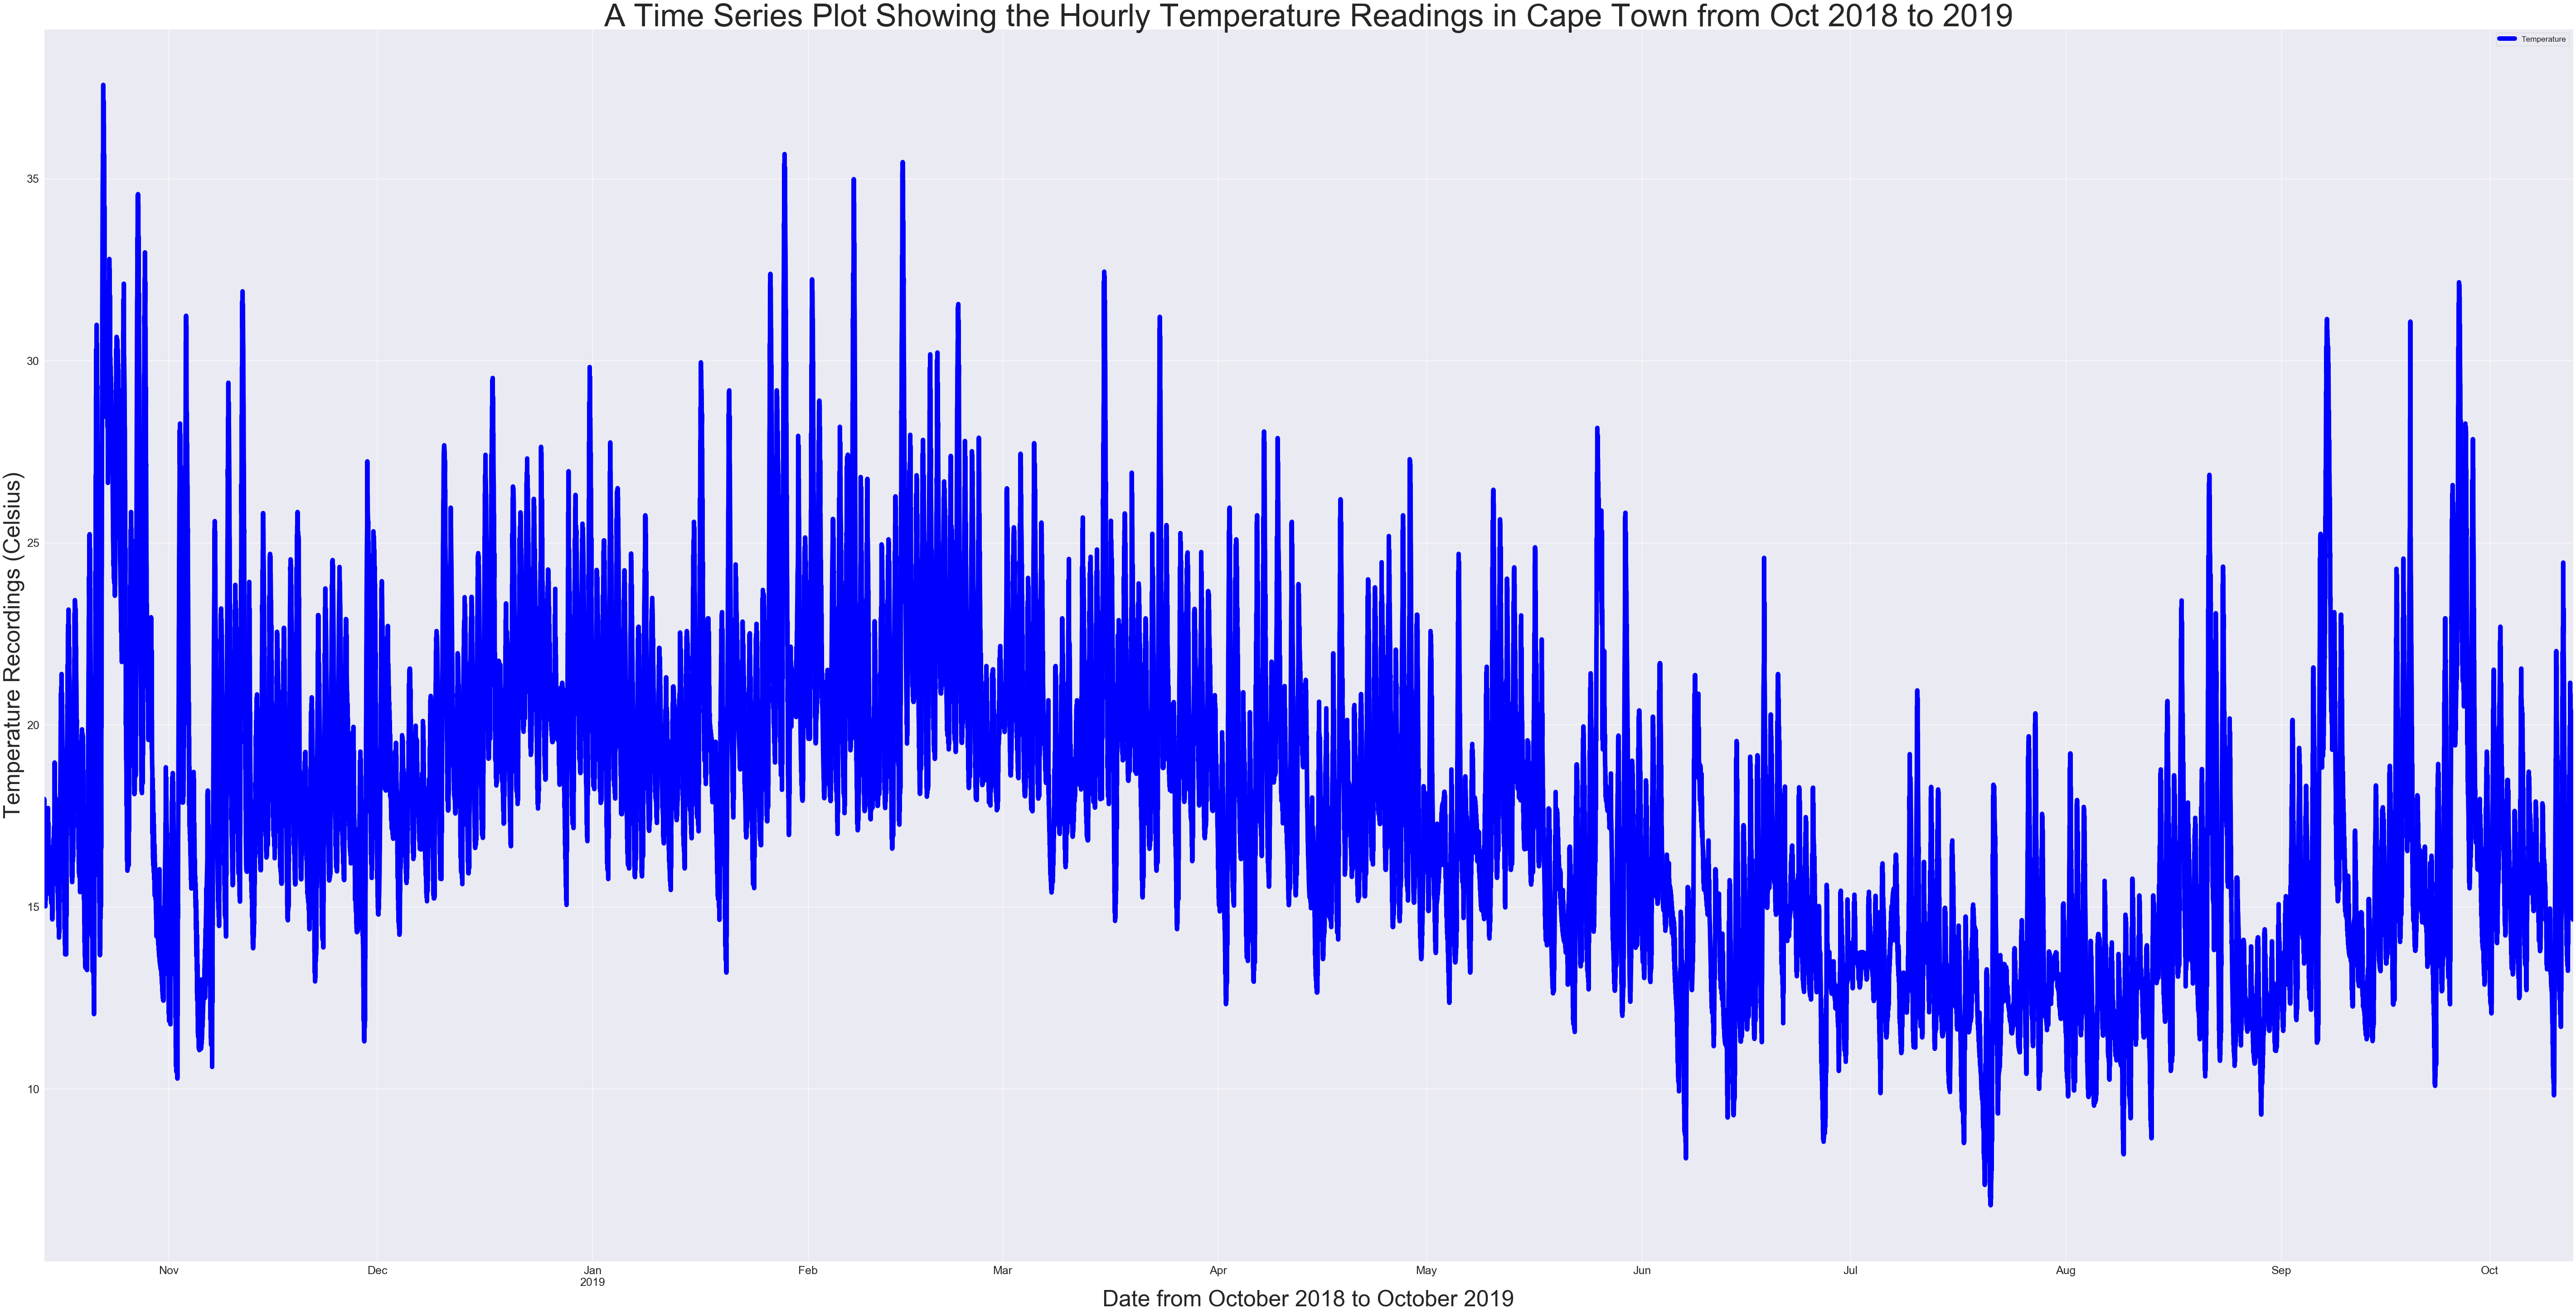

In [ ]:
weather_data_indxed = temperature_df.set_index('DateTime')
weather_data_indxed.plot(color='blue', linewidth=10)
plt.title("A Time Series Plot Showing the Hourly Temperature Readings in Cape Town from Oct 2018 to 2019")
plt.xlabel("Date from October 2018 to October 2019")
plt.ylabel("Temperature Recordings (Celsius)")

Text(0, 0.5, 'Temperature Recordings (Celsius)')

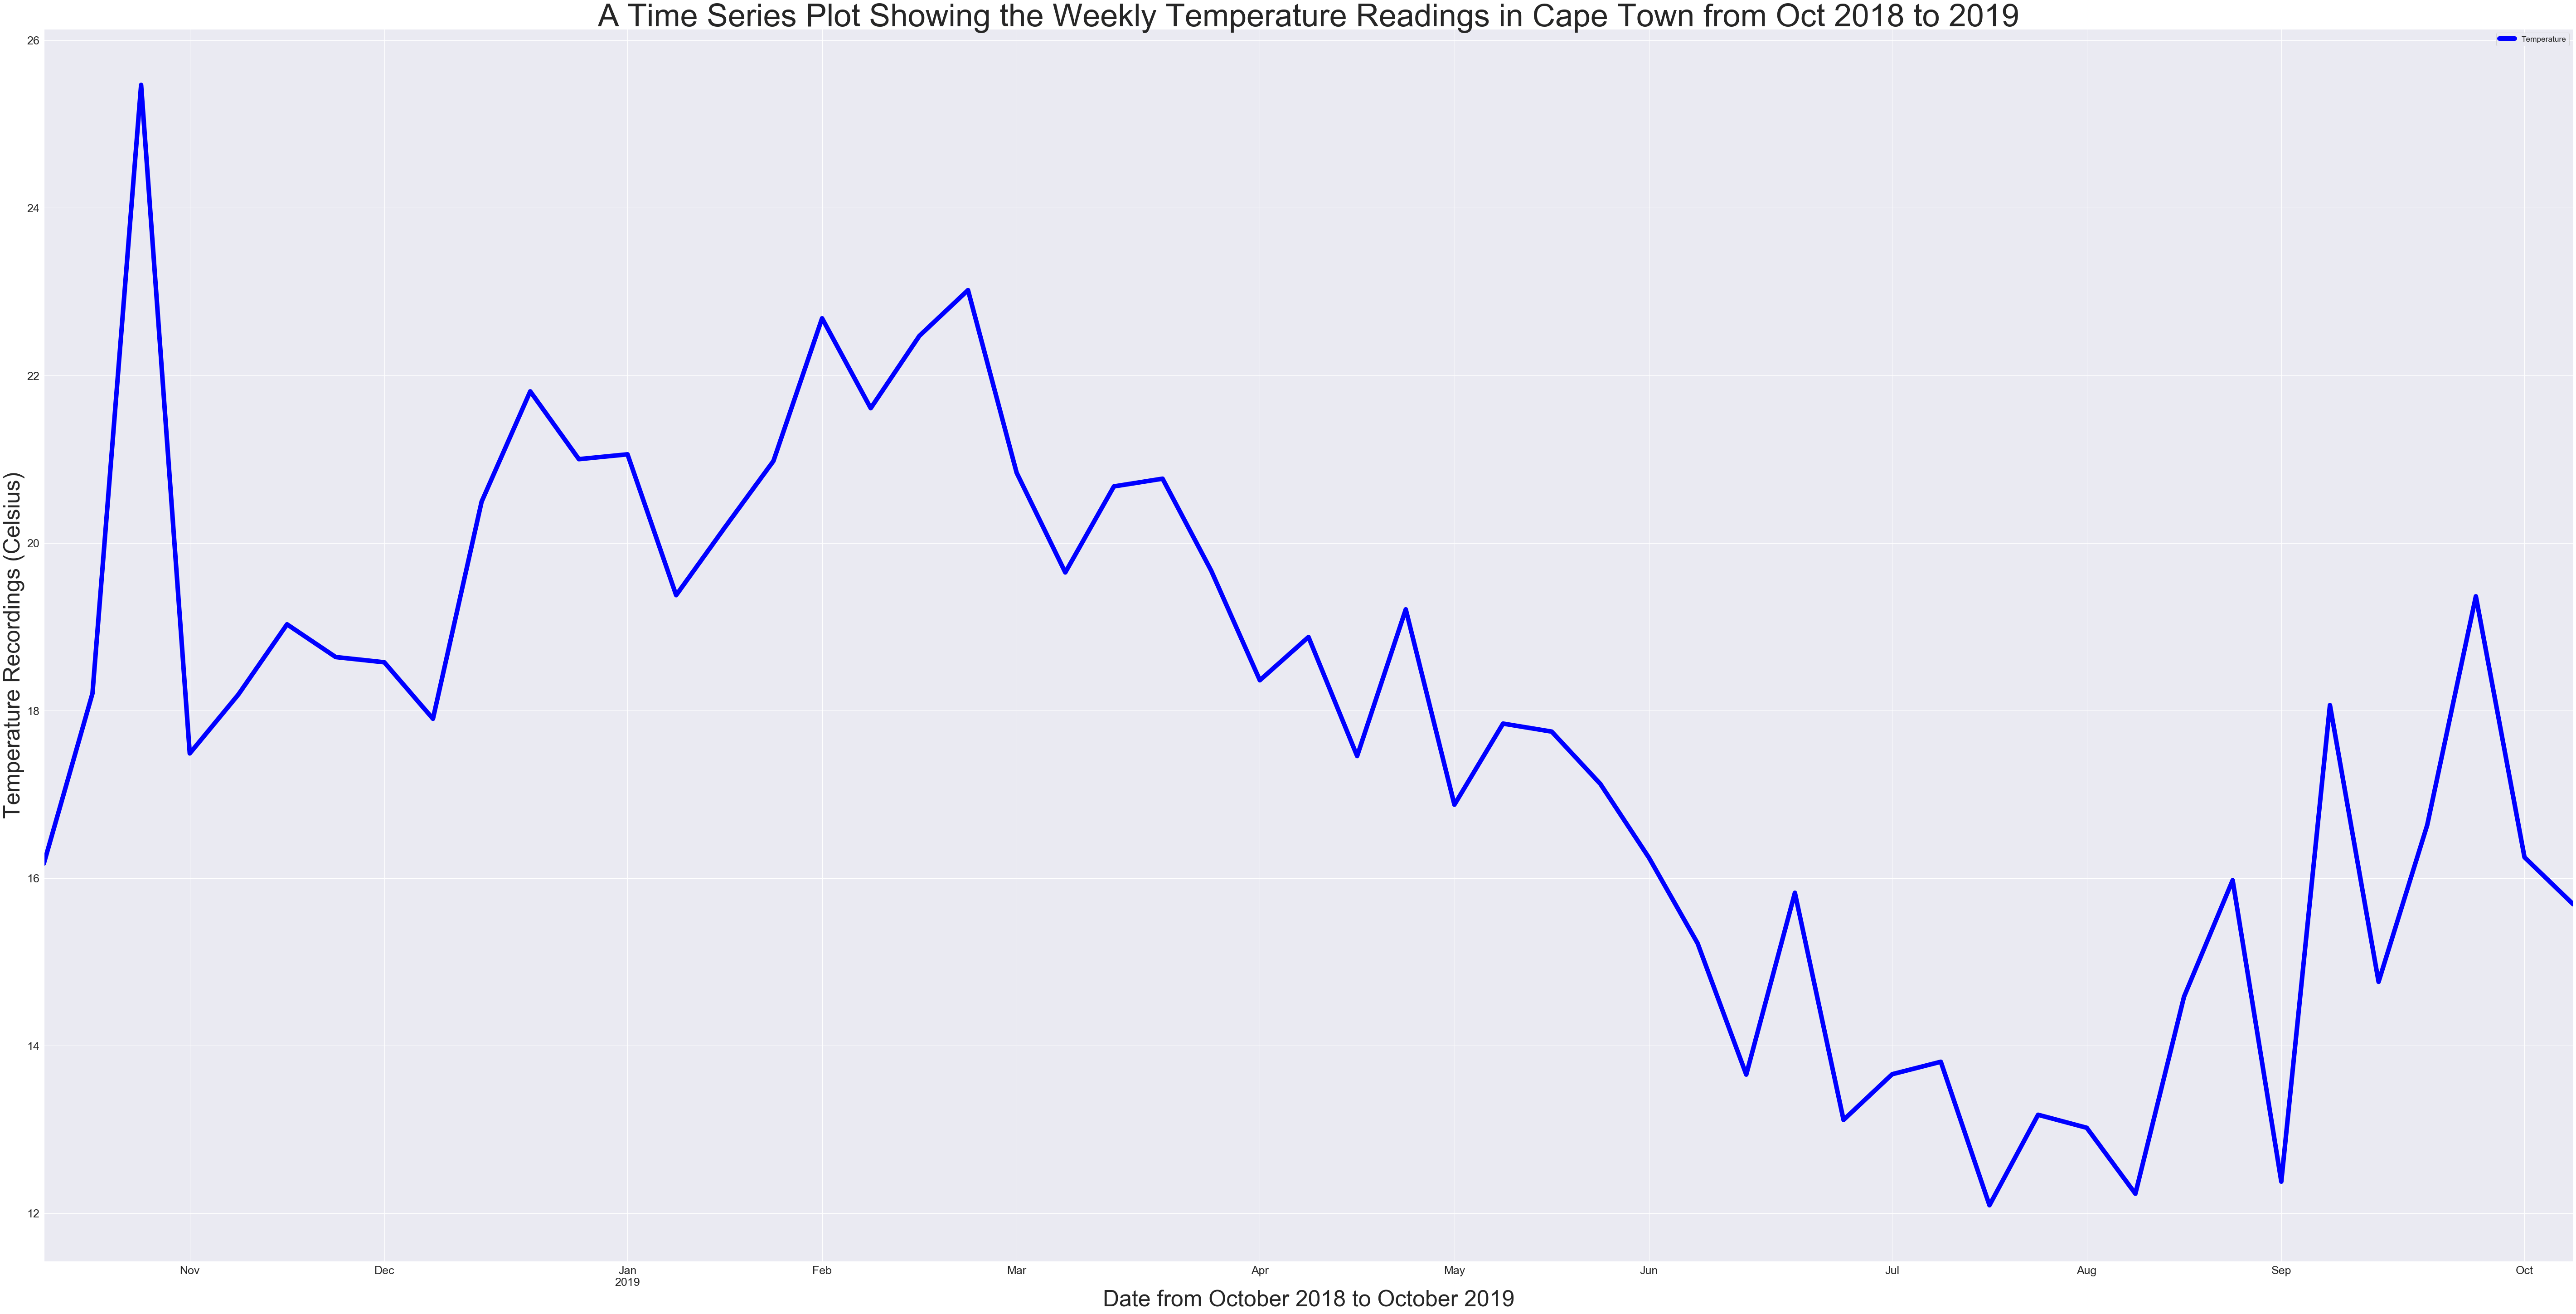

In [ ]:
## Resampling Techniques again
weather_weekly = weather_data_indxed.resample('W').mean()
weather_weekly.plot(color='blue', linewidth=10)
plt.title("A Time Series Plot Showing the Weekly Temperature Readings in Cape Town from Oct 2018 to 2019")
plt.xlabel("Date from October 2018 to October 2019")
plt.ylabel("Temperature Recordings (Celsius)")

Text(0, 0.5, 'Temperature Recordings (Celsius)')

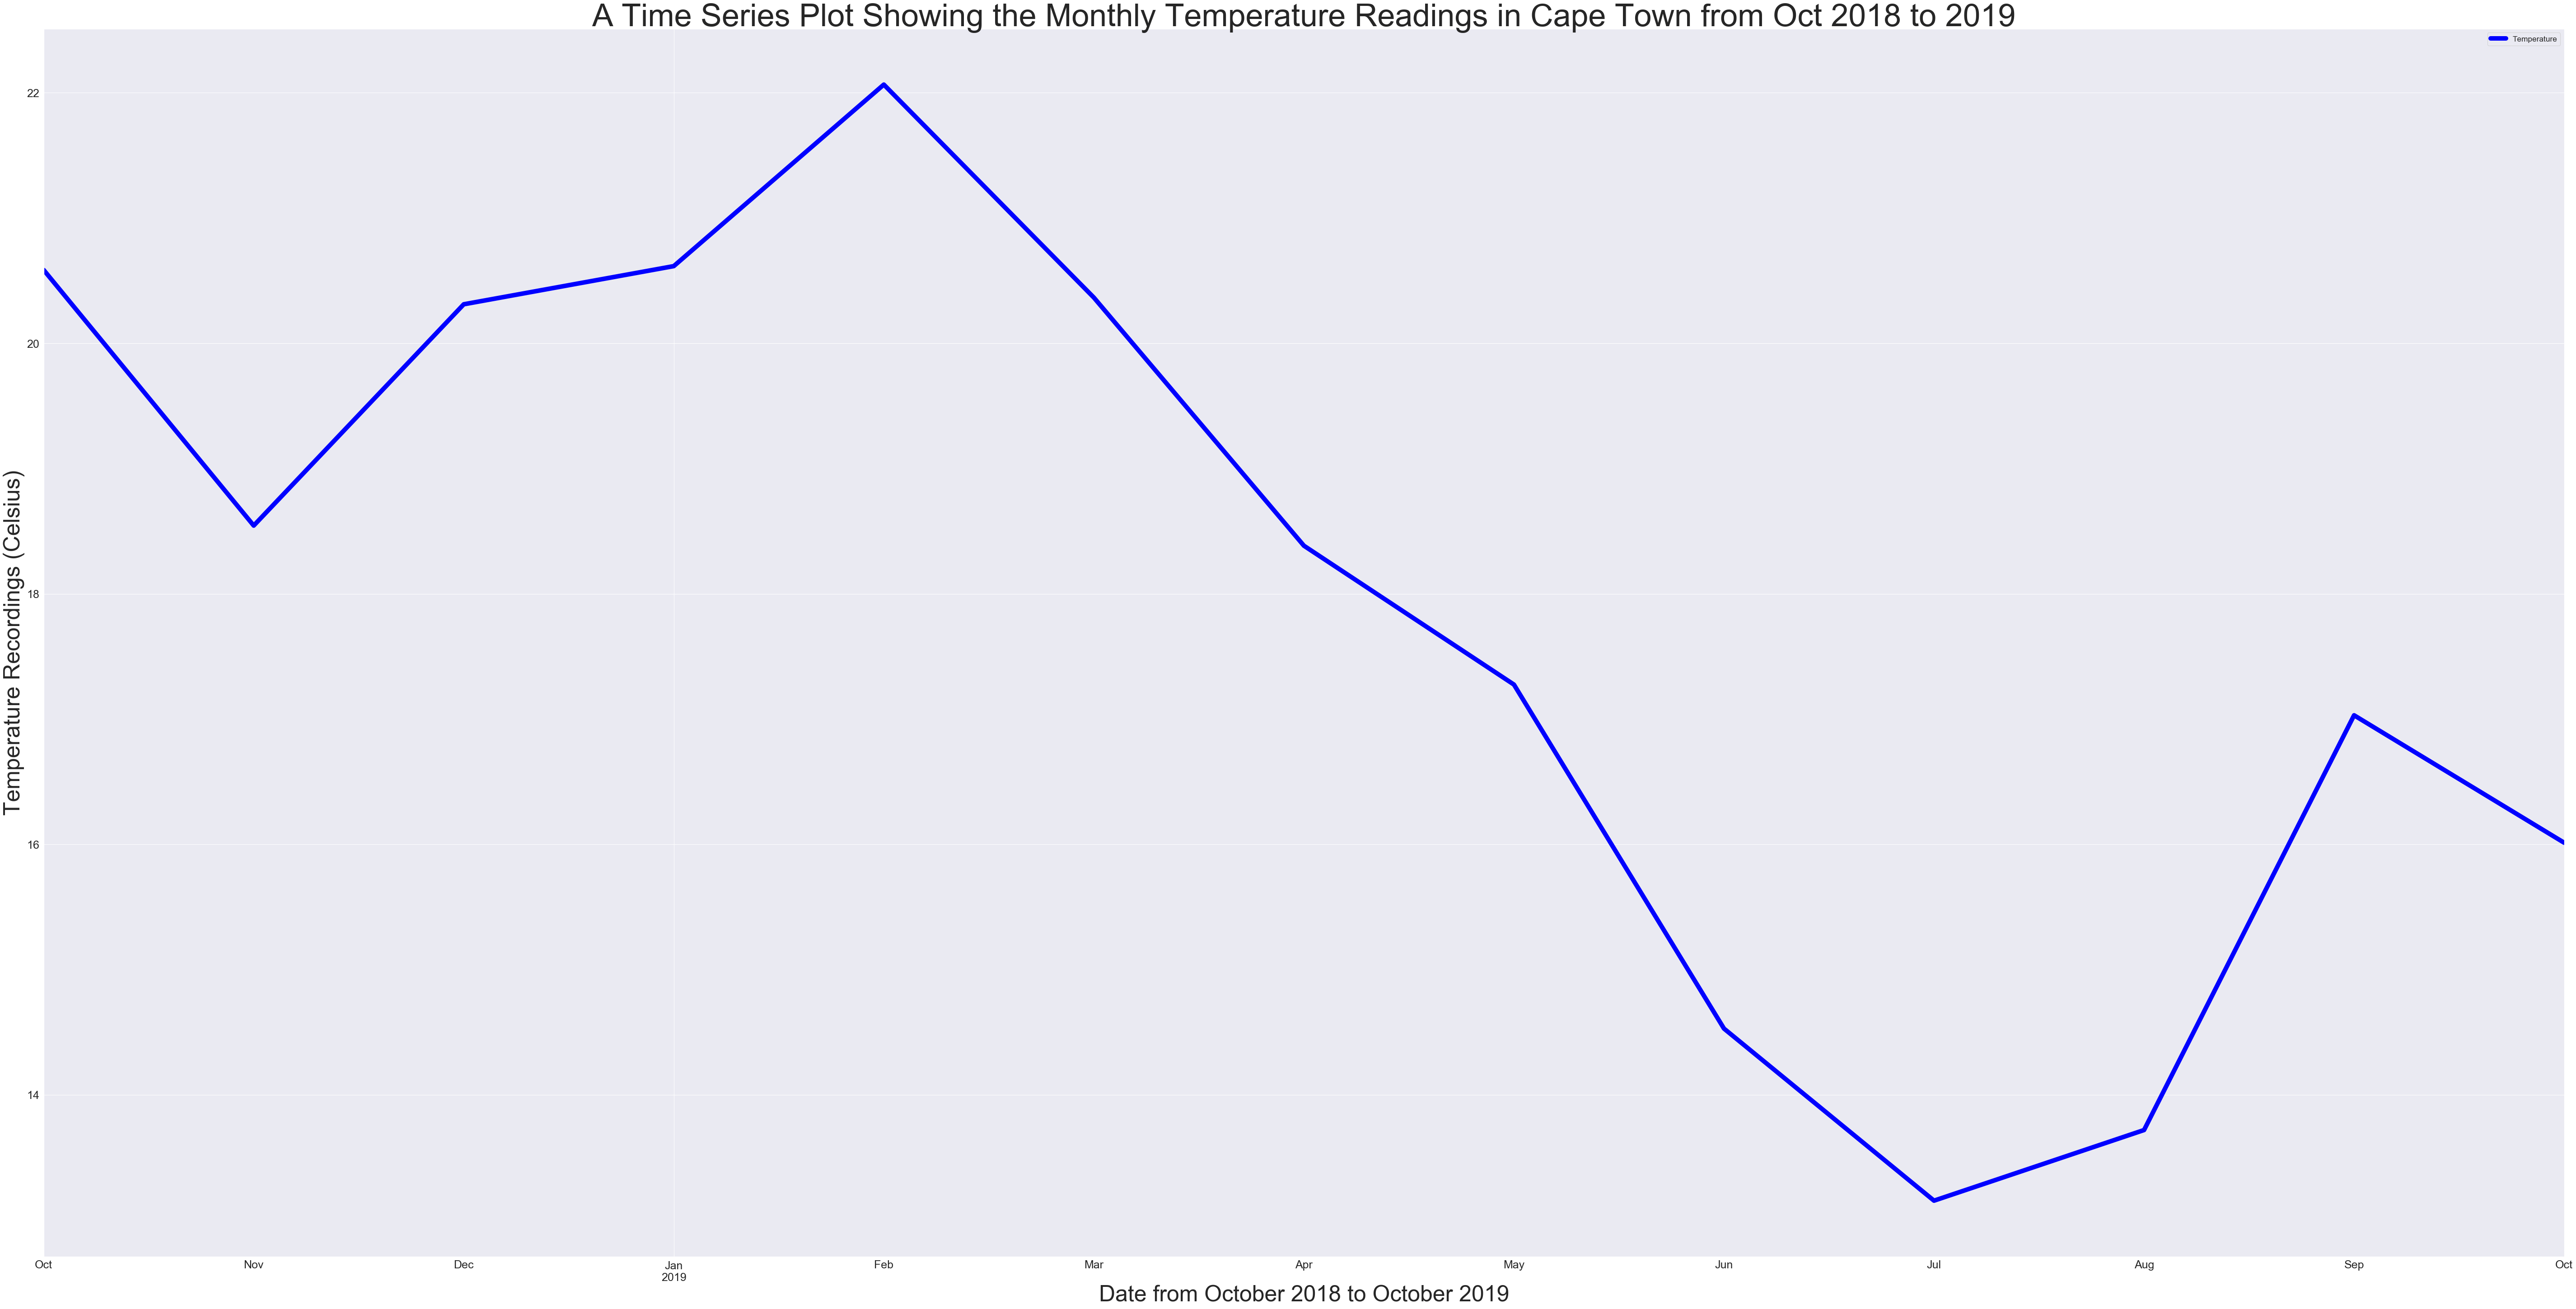

In [ ]:
weather_monthly = weather_data_indxed.resample('M').mean()
weather_monthly.plot(color='blue', linewidth=10)
plt.title("A Time Series Plot Showing the Monthly Temperature Readings in Cape Town from Oct 2018 to 2019")
plt.xlabel("Date from October 2018 to October 2019")
plt.ylabel("Temperature Recordings (Celsius)")

Text(0, 0.5, 'Temperature Recordings (Celsius)')

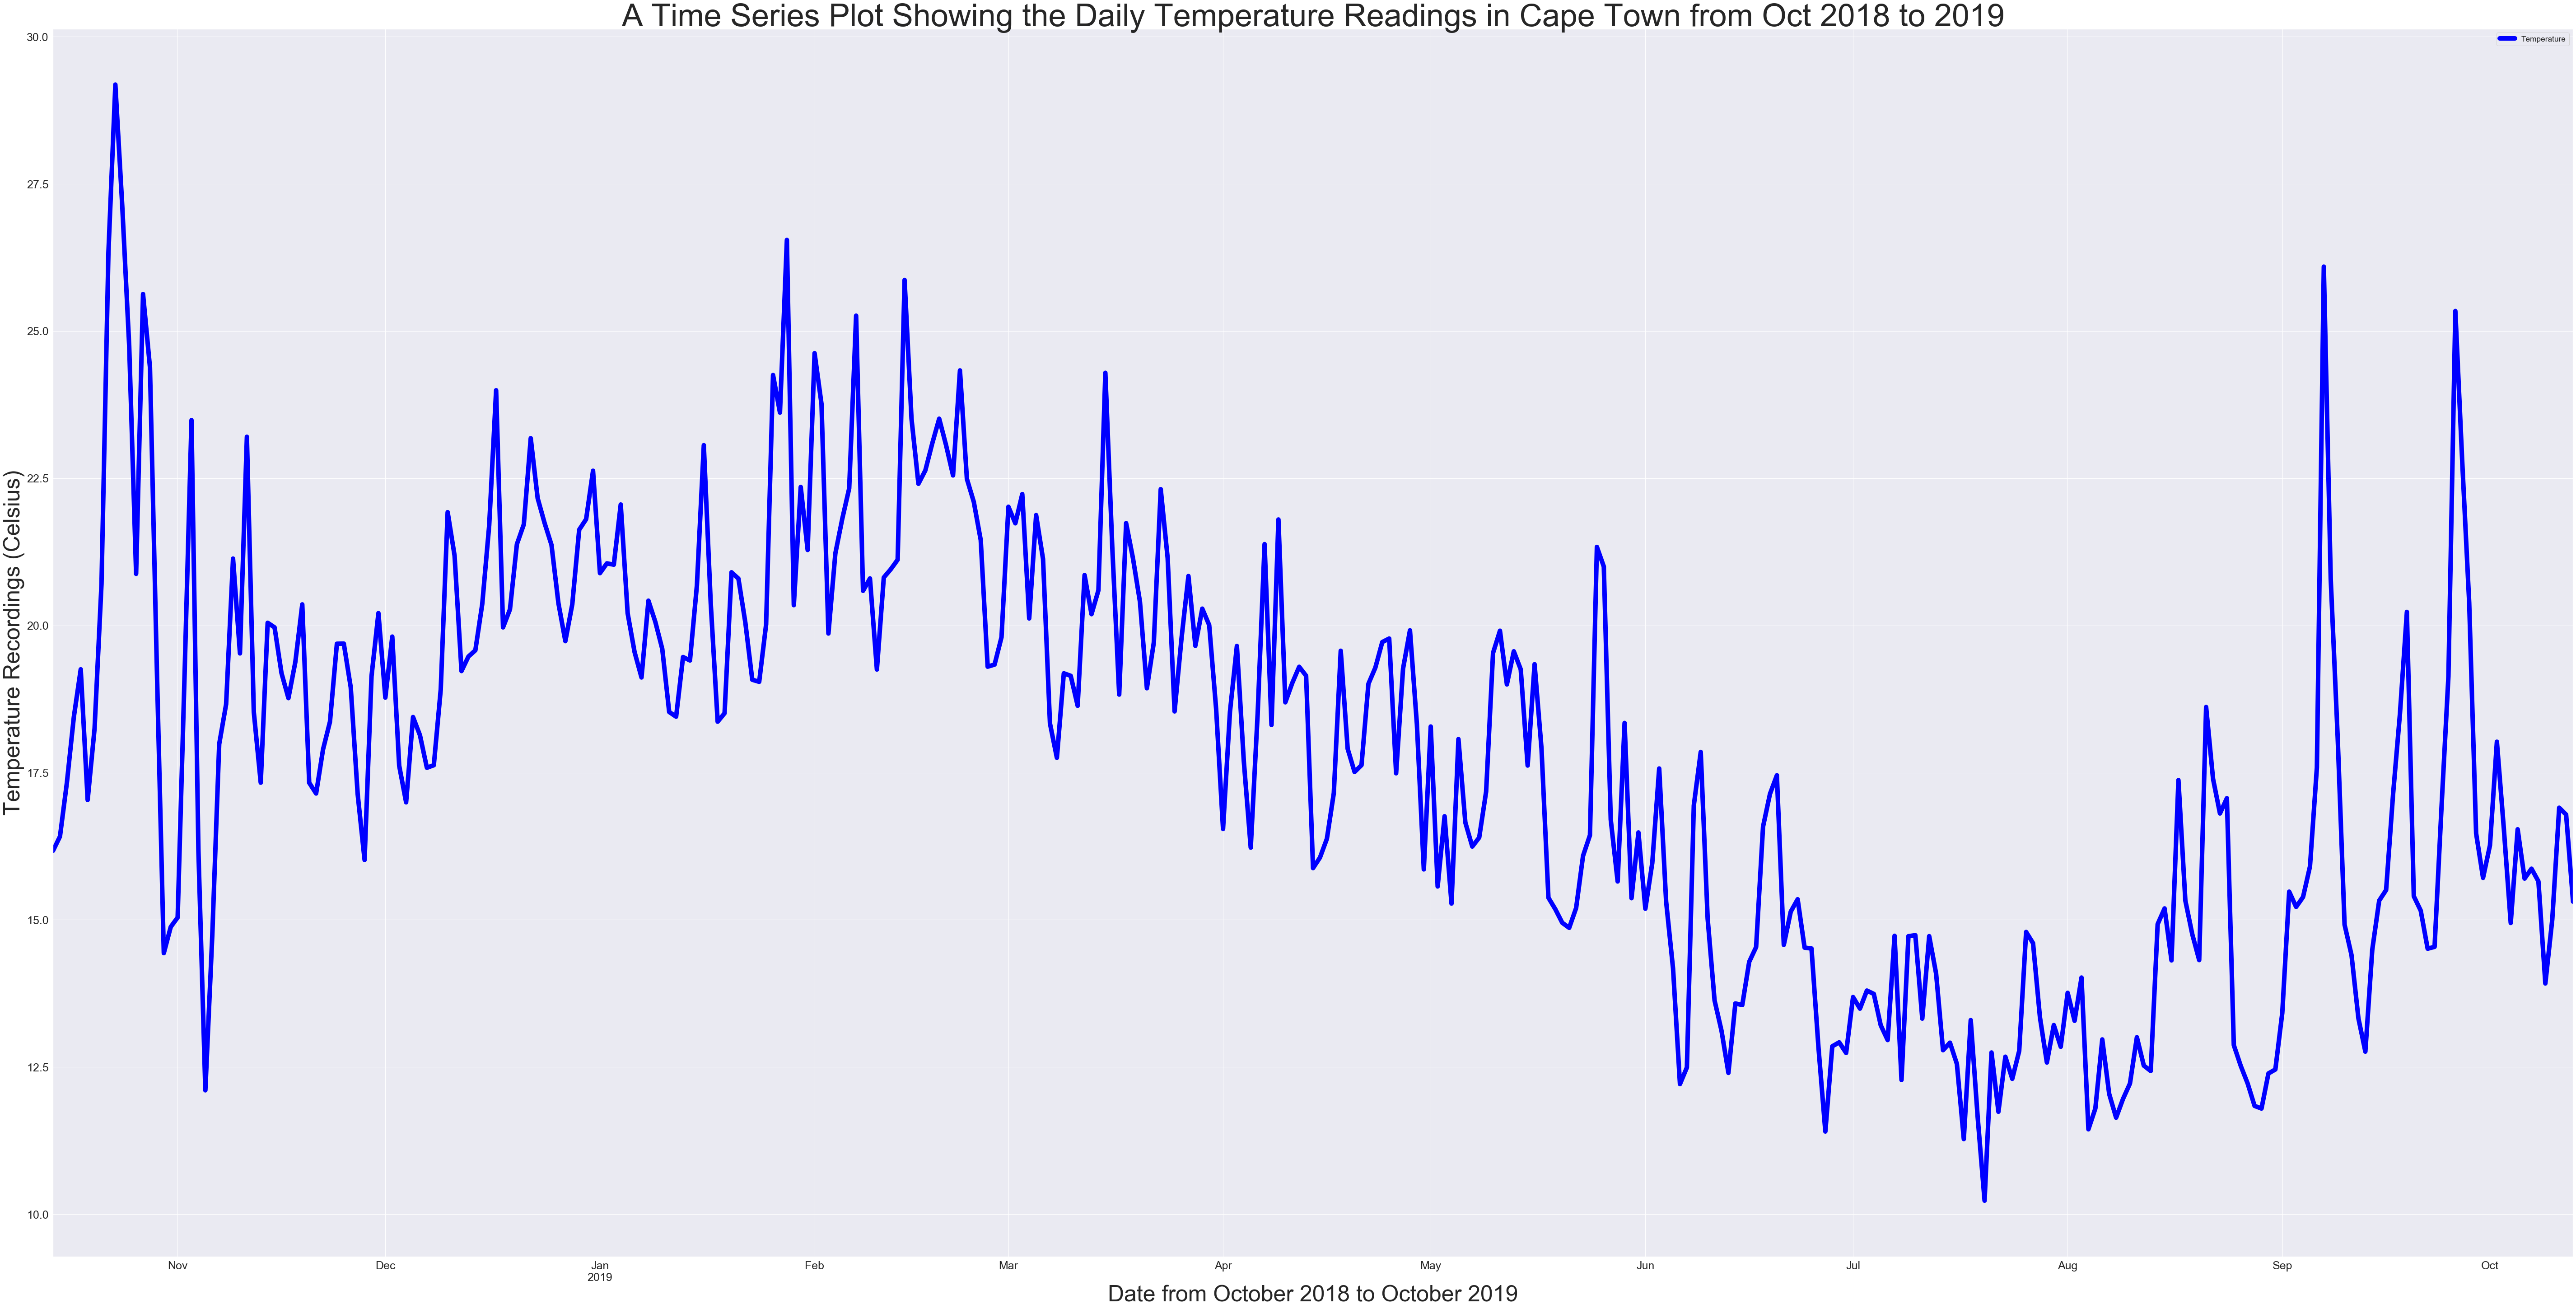

In [ ]:
weather_daily = weather_data_indxed.resample('D').mean()
weather_daily.plot(color='blue', linewidth=10)
plt.title("A Time Series Plot Showing the Daily Temperature Readings in Cape Town from Oct 2018 to 2019")
plt.xlabel("Date from October 2018 to October 2019")
plt.ylabel("Temperature Recordings (Celsius)")

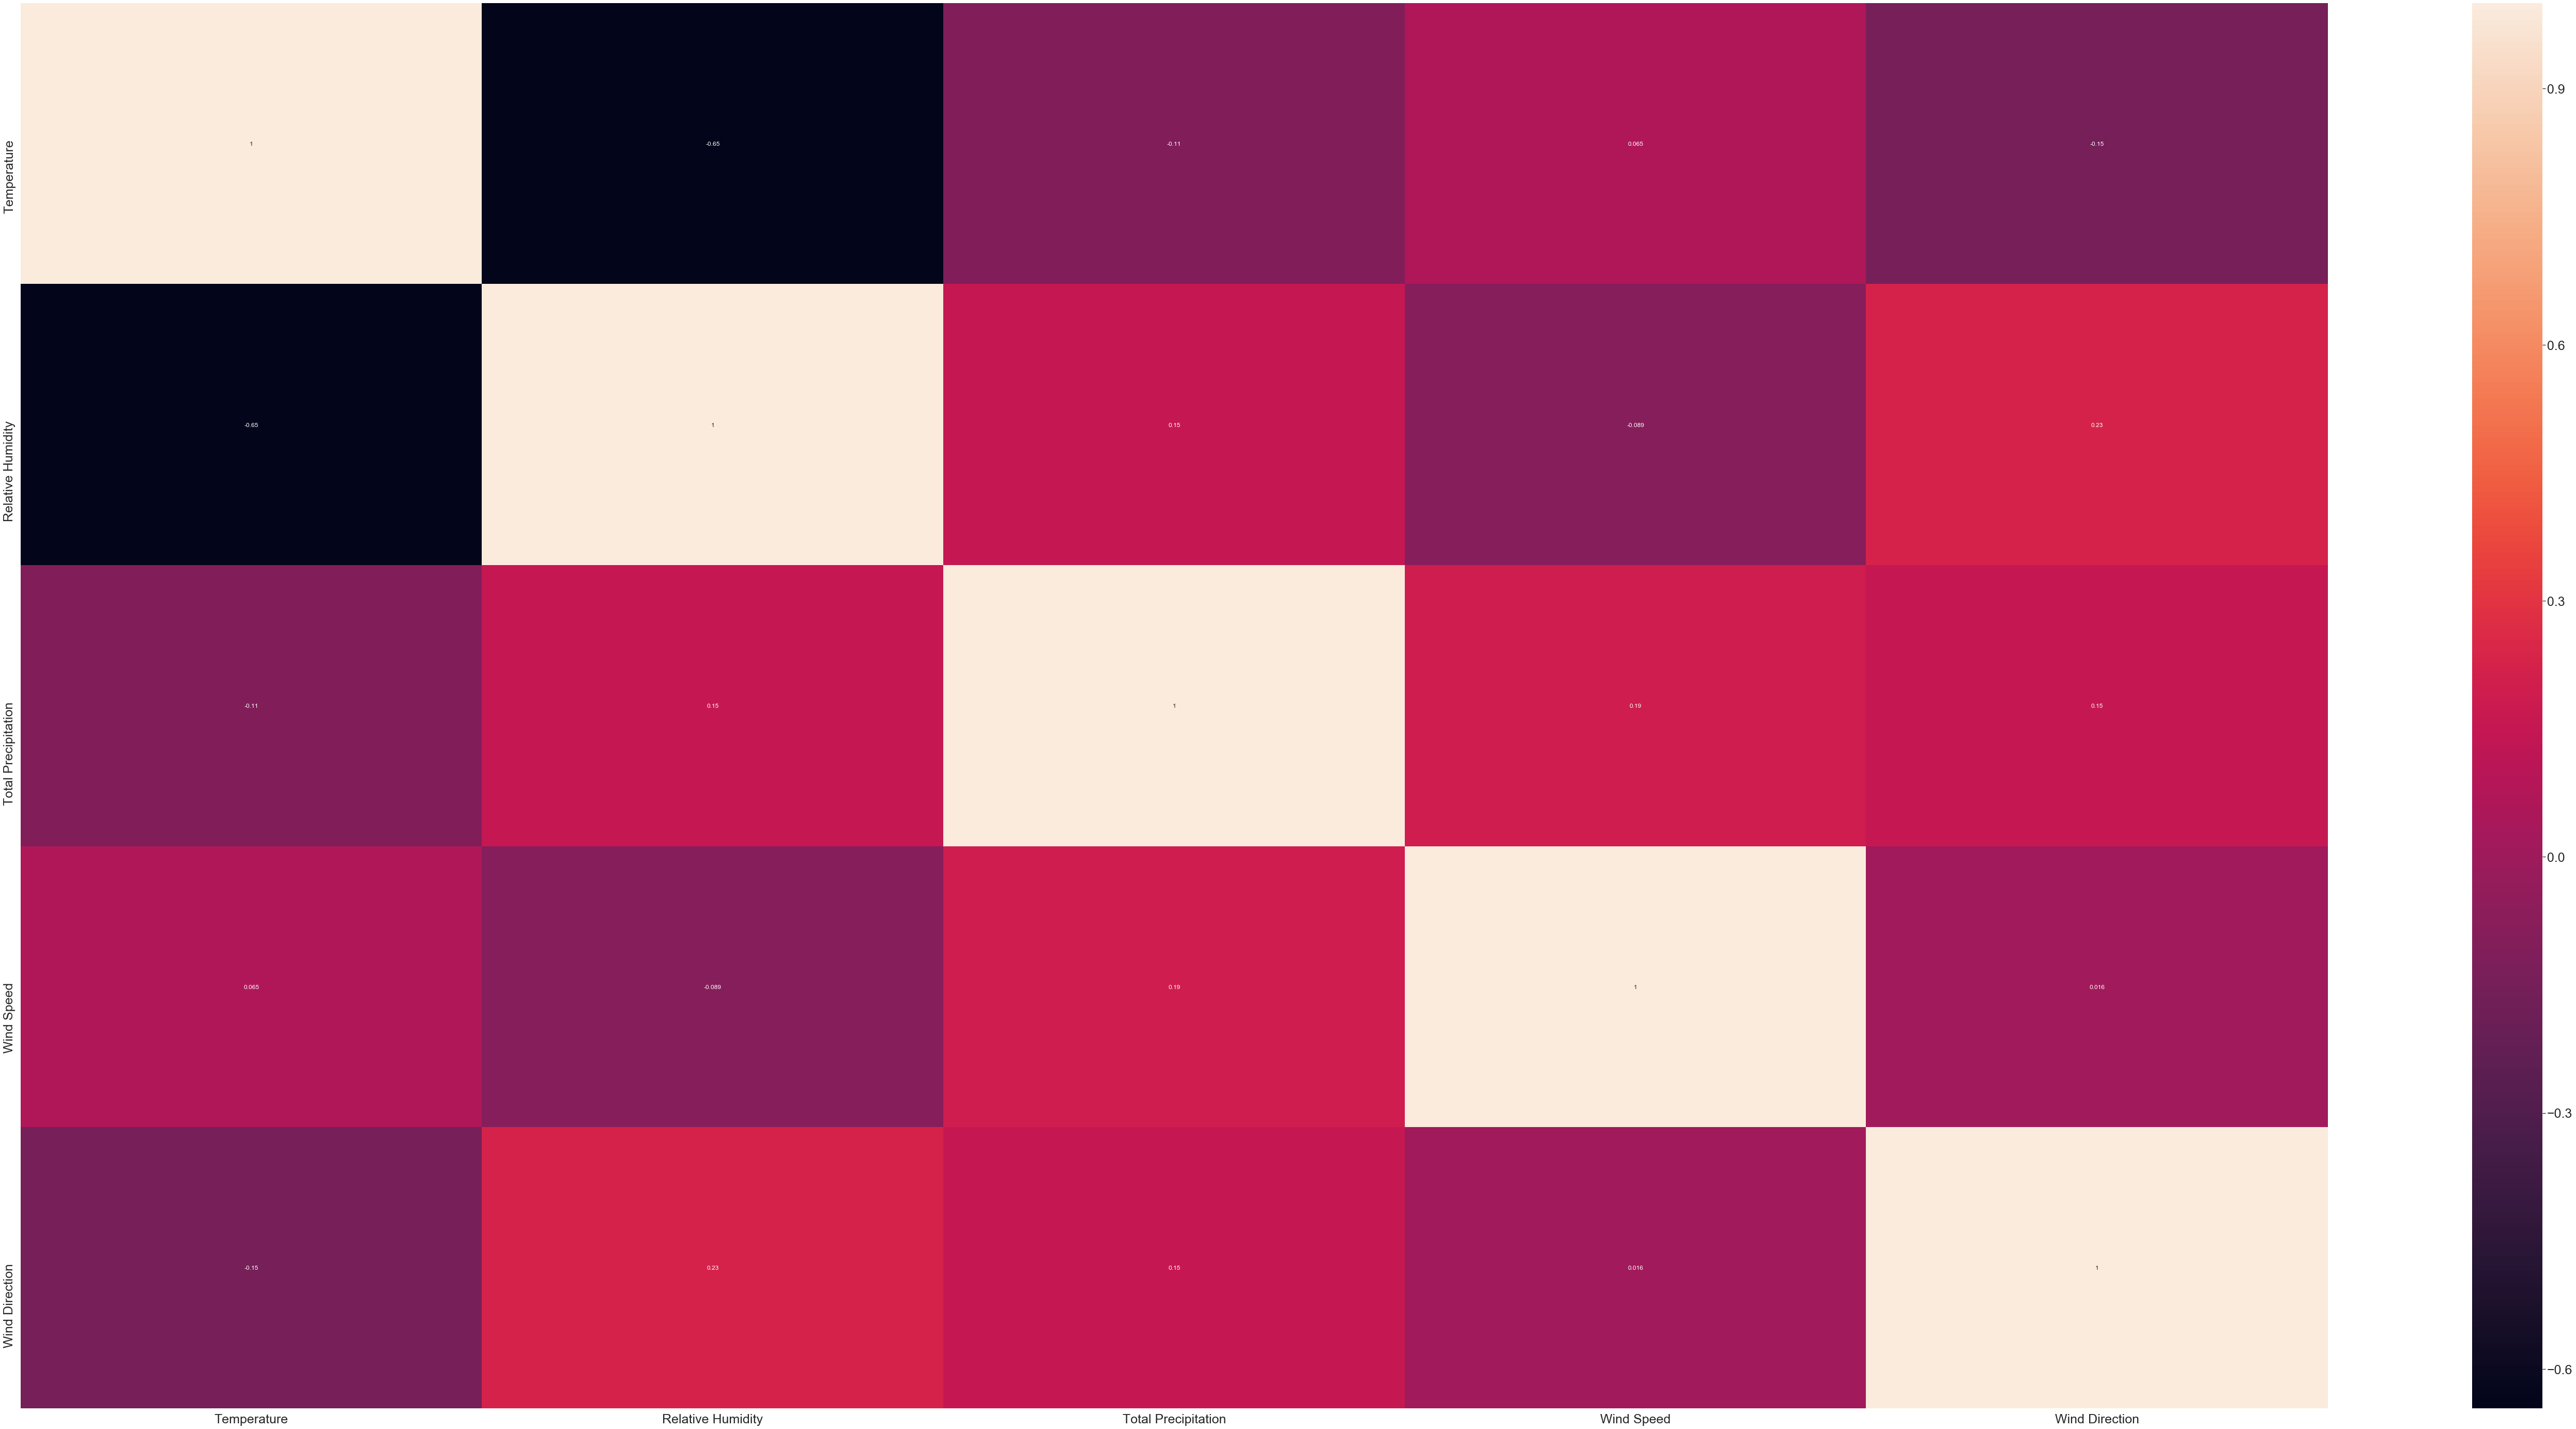

In [ ]:
## Correlation between weather variables
only_weather_vars = weather_df[["Temperature", "Relative Humidity", "Total Precipitation", "Wind Speed", "Wind Direction"]]
sns.heatmap(only_weather_vars.corr(), annot=True)

In [ ]:
## Comment on the heatmpa above
## As you can see, the temperature variable is highly negatively correlated with relative humidity so adding it will lead to multicollinearity

### Merge Datasets

In [ ]:
merged_df = pd.merge(bulk_meter_df, temperature_df, on='DateTime')
#test_df["Power (kW)"] = np.nan
time_series = pd.concat([merged_df, test_df], axis=0).reset_index(drop=True)
time_series.head()

DateTime  Power (kW)  Temperature
0 2018-10-14 00:30:00     10.1980    17.736810
1 2018-10-14 01:00:00      8.2462    17.860000
2 2018-10-14 01:30:00     10.1980    17.500270
3 2018-10-14 02:00:00     12.0000    17.960000
4 2018-10-14 02:30:00      8.9443    17.276532

Text(0, 0.5, 'Bulk Meter Load (kW)')

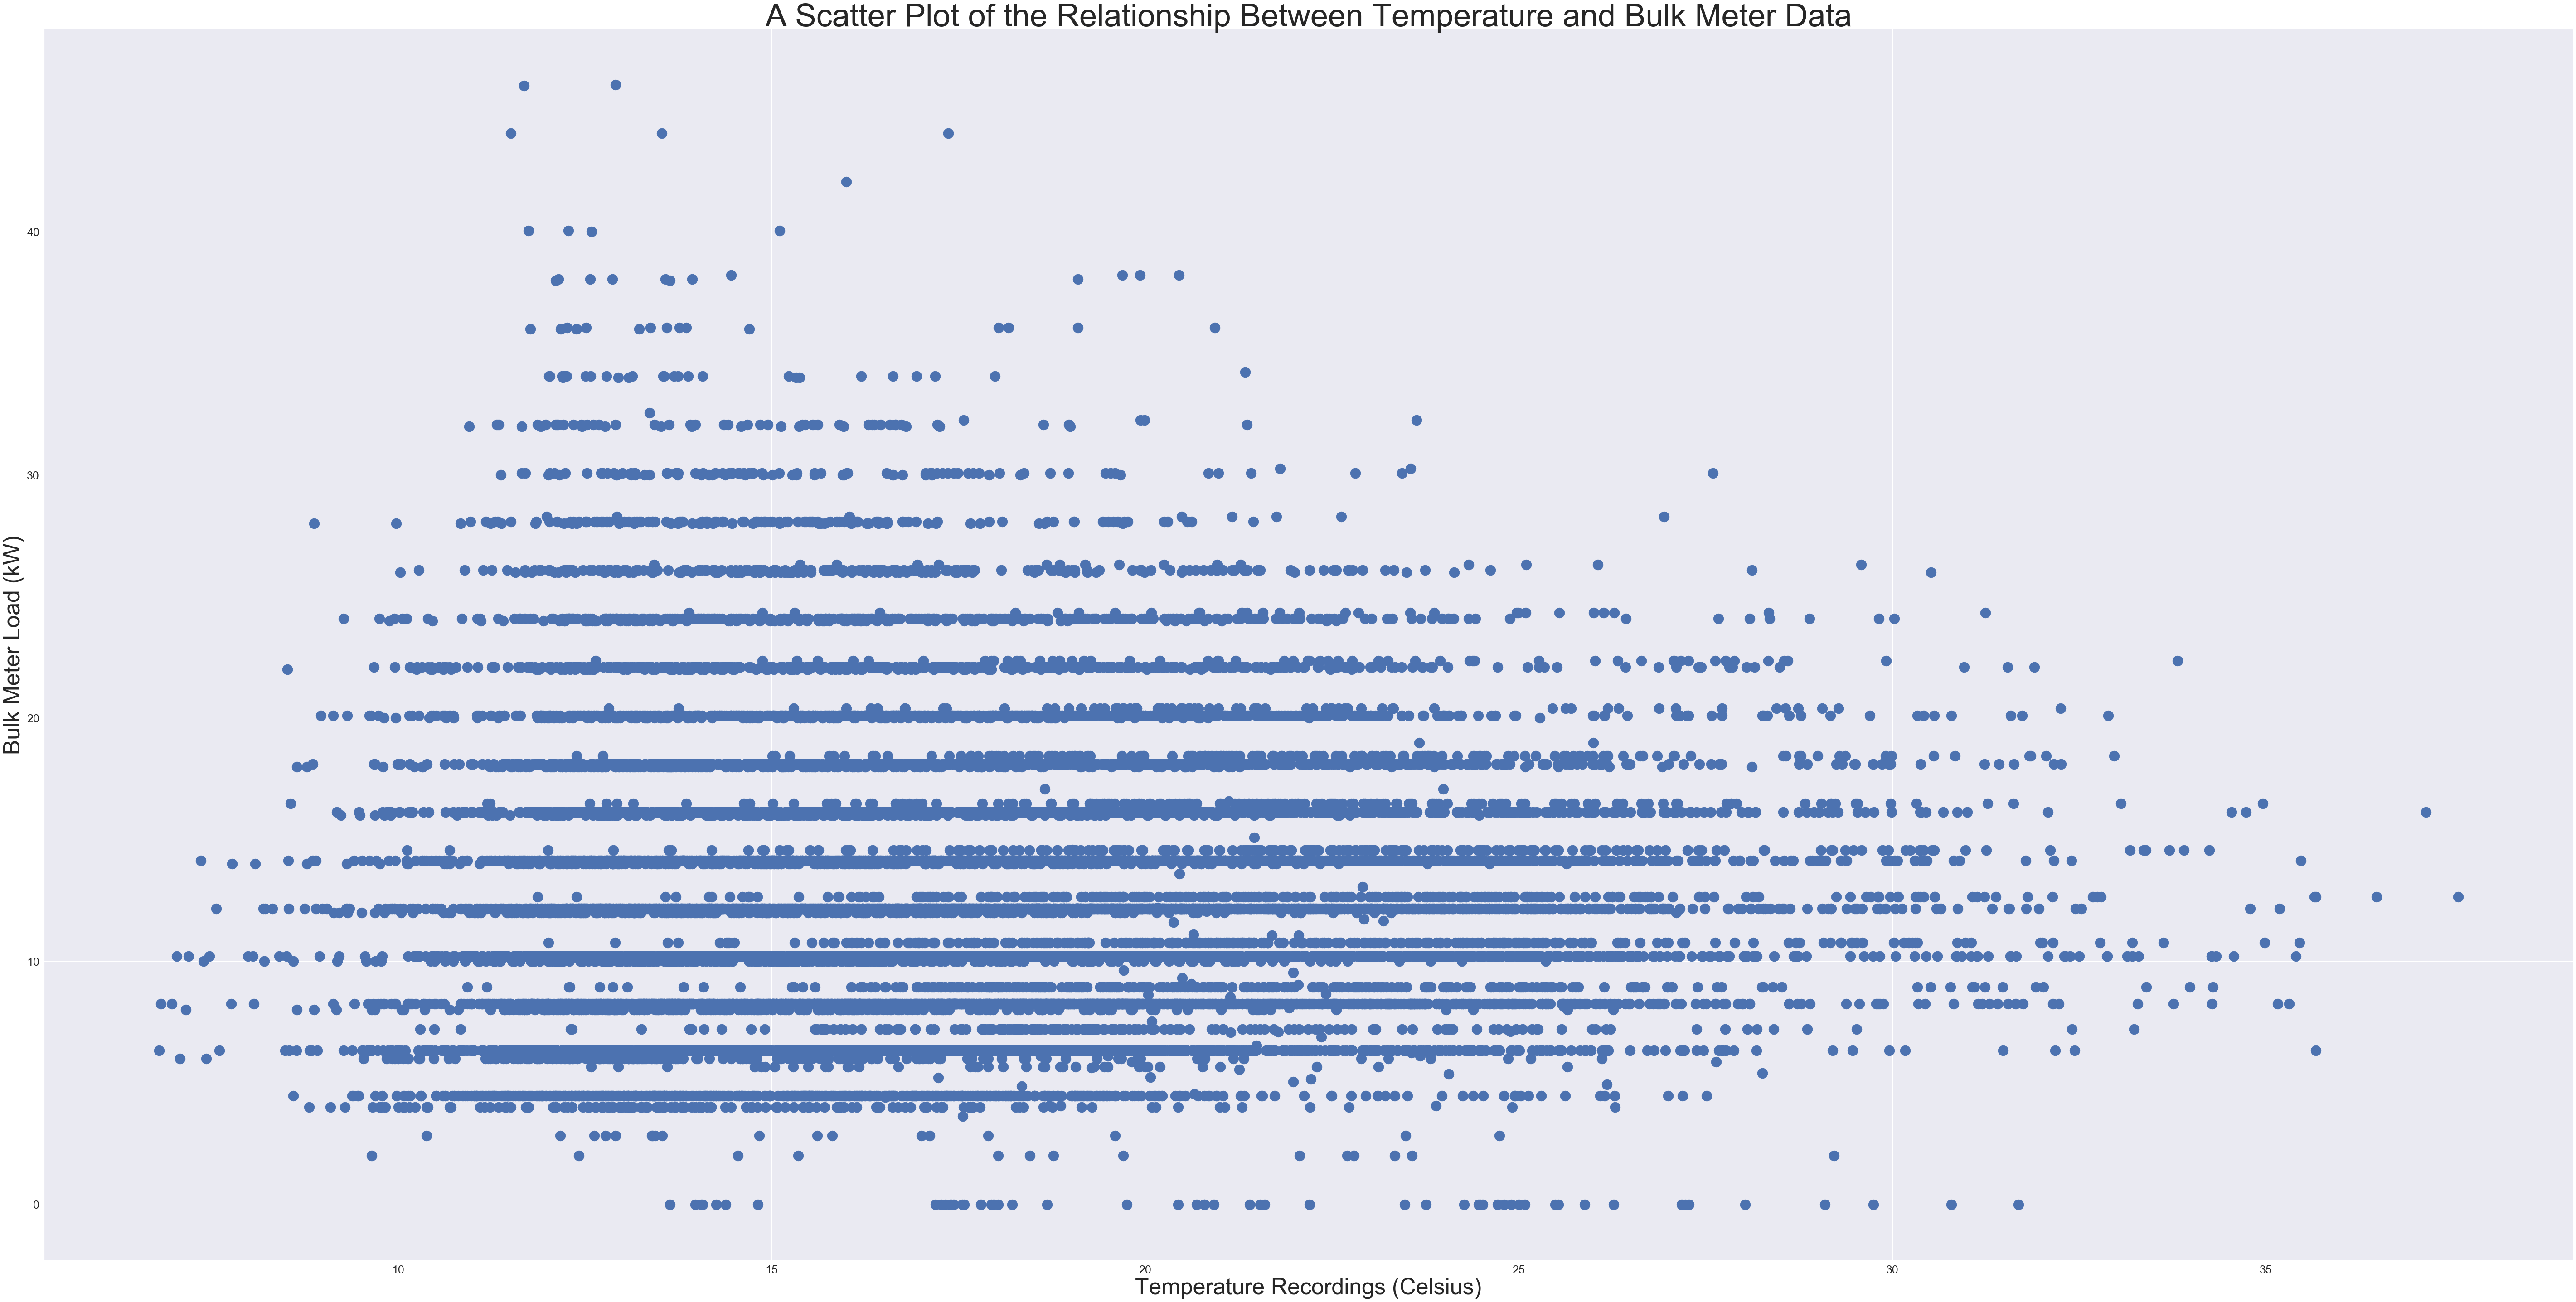

In [ ]:
## Scatter Plot of the Relationship Between Temperature and Bulk Meter Data
plt.scatter(merged_df["Temperature"], merged_df["Power (kW)"], s=500)
plt.title("A Scatter Plot of the Relationship Between Temperature and Bulk Meter Data")
plt.xlabel("Temperature Recordings (Celsius)")
plt.ylabel("Bulk Meter Load (kW)")

### Find Coorelation

In [ ]:
merged_df.corr()

Power (kW)  Temperature
Power (kW)     1.000000    -0.000583
Temperature   -0.000583     1.000000

In [ ]:
## There seem to be a weak negative relationship between the two variables

# Feature Engineering

In [ ]:
## Days of the week, months of the year, hours of the day
time_series["Month"] = time_series["DateTime"].dt.month_name()
time_series["WeekName"] = time_series["DateTime"].dt.weekday_name
time_series["HourOfDay"] = time_series["DateTime"].dt.hour


In [ ]:
## Transform the hours of daily from the numerical into a cyclical nature, revealing the true hourly difference between 2 hours
time_series["SineHourOfDay"] = np.sin(2 * np.pi * time_series["HourOfDay"] / 48)
time_series["CosineHourOfDay"] = np.cos(2 * np.pi * time_series["HourOfDay"] / 48)


In [ ]:
### National holidays
#https://www.gov.za/about-sa/public-holidays
#South Africa has 12 public holidays as determined by the Public Holidays Act (Act No 36 of 1994)

public_holidays = ["12-16", "12-24", "12-25", "12-26", "12-30", "12-31", "01-01", "01-02", "01-03", "03-21", 
                   "04-10", "04-13", "04-27", "05-01", "06-16", "08-09", "08-10", "09-24"]

day_month = time_series.DateTime.map(lambda x: x.strftime('%m-%d'))
public_holidays = np.array([1 if x in public_holidays else 0 for x in day_month ])
time_series["IsHoliday"] = public_holidays
merged_df.head()

## sessions of the day
session_of_day_bins = [-1,4,8,12,16,20,24]
labels = ['Dawn', 'Early Morning','Morning','Afternoon','Evening','Night']
time_series['Day_Period'] = pd.cut(time_series["HourOfDay"], bins=session_of_day_bins, labels=labels)


### Label Encoding - One-hot Encoding

In [ ]:
##convert the categorial values into a one-hot-encoded feature, to avoid giving high prefence to hours like 23 and months like 11
encoded_days_of_week = pd.get_dummies(time_series["WeekName"])
encoded_months_of_year = pd.get_dummies(time_series["Month"])
encoded_hour_of_year = pd.get_dummies(time_series["HourOfDay"], prefix="Hour_")
encoded_day_period = pd.get_dummies(time_series["Day_Period"])

##join the one hot encoded values
time_series = time_series.join(encoded_days_of_week)
time_series = time_series.join(encoded_months_of_year)
time_series = time_series.join(encoded_hour_of_year)
time_series = time_series.join(encoded_day_period)

##drop the original values after one hot encoding
time_series = time_series.drop(["WeekName", "HourOfDay", "Month", "Day_Period"], axis=1)
time_series.head()

DateTime  Power (kW)  Temperature  SineHourOfDay  \
0 2018-10-14 00:30:00     10.1980    17.736810       0.000000   
1 2018-10-14 01:00:00      8.2462    17.860000       0.130526   
2 2018-10-14 01:30:00     10.1980    17.500270       0.130526   
3 2018-10-14 02:00:00     12.0000    17.960000       0.258819   
4 2018-10-14 02:30:00      8.9443    17.276532       0.258819   

   CosineHourOfDay  IsHoliday  Friday  Monday  Saturday  Sunday  ...  \
0         1.000000          0       0       0         0       1  ...   
1         0.991445          0       0       0         0       1  ...   
2         0.991445          0       0       0         0       1  ...   
3         0.965926          0       0       0         0       1  ...   
4         0.965926          0       0       0         0       1  ...   

   Hour__20  Hour__21  Hour__22  Hour__23  Dawn  Early Morning  Morning  \
0         0         0         0         0     1              0        0   
1         0         0         0         0     1              0        0   
2         0         0         0         0     1              0        0   
3         0         0         0         0     1              0        0   
4         0         0         0         0     1              0        0   

   Afternoon  Evening  Night  
0          0        0      0  
1          0        0      0  
2          0        0      0  
3          0        0      0  
4          0        0      0  

[5 rows x 55 columns]

### More features: delayed bulk load data (t-1 and t-2)

In [ ]:

##delayed bulk meter data
delayed_load_df = pd.DataFrame()

## test two lags
for x in range(1,3):
    delayed_load_df['Delayed_' + str(x)] = time_series.iloc[:,1].shift(x)

    
## Interpolate missing values
delayed_load_df_columns = delayed_load_df.columns
delayed_load_df[delayed_load_df_columns] = delayed_load_df[delayed_load_df_columns].apply(lambda x: x.interpolate(method='linear'), axis=1)
delayed_load_df.fillna(np.mean(delayed_load_df), inplace=True)

time_series['Delayed_30_Mins_Ago'] = delayed_load_df["Delayed_1"]
time_series['Delayed_1_Hour_Ago'] = delayed_load_df["Delayed_2"]


time_series.head()

DateTime  Power (kW)  Temperature  SineHourOfDay  \
0 2018-10-14 00:30:00     10.1980    17.736810       0.000000   
1 2018-10-14 01:00:00      8.2462    17.860000       0.130526   
2 2018-10-14 01:30:00     10.1980    17.500270       0.130526   
3 2018-10-14 02:00:00     12.0000    17.960000       0.258819   
4 2018-10-14 02:30:00      8.9443    17.276532       0.258819   

   CosineHourOfDay  IsHoliday  Friday  Monday  Saturday  Sunday  ...  \
0         1.000000          0       0       0         0       1  ...   
1         0.991445          0       0       0         0       1  ...   
2         0.991445          0       0       0         0       1  ...   
3         0.965926          0       0       0         0       1  ...   
4         0.965926          0       0       0         0       1  ...   

   Hour__22  Hour__23  Dawn  Early Morning  Morning  Afternoon  Evening  \
0         0         0     1              0        0          0        0   
1         0         0     1              0        0          0        0   
2         0         0     1              0        0          0        0   
3         0         0     1              0        0          0        0   
4         0         0     1              0        0          0        0   

   Night  Delayed_30_Mins_Ago  Delayed_1_Hour_Ago  
0      0            13.045981           13.045818  
1      0            10.198000           10.198000  
2      0             8.246200           10.198000  
3      0            10.198000            8.246200  
4      0            12.000000           10.198000  

[5 rows x 57 columns]

## Feature Selection

### Stepwise Regression to Select Useful Features

In [ ]:
#Reference: Function adapted from the author of stepwise-regression
#Module: Stepwise Regression
#Author: Aakkash Vijayakumar
#URL: https://github.com/AakkashVijayakumar/stepwise-regression
#Date Retrieved: April 07, 2020

def forward_regression(X, y, threshold_in):
    
    initial_list = []
    included = list(initial_list)
    model = None
    
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
            
        best_pval = new_pval.min()
        
        ##Determining best predictor by comparing the one with the minimum p-value against the alpha value of 0.05
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            print('Feature Added: {0} with p-value {1}'.format(best_feature, round(best_pval, 5)))

        if not changed:
            break

    return [model, included]

In [ ]:
##Split Data Into X and Y
local_train = time_series.loc[time_series.DateTime <= '2019-10-13'].reset_index(drop=True)
local_test_ = time_series.loc[time_series.DateTime > '2019-10-13'].reset_index(drop=True)

X = local_train.iloc[:,2:]
y = local_train.iloc[:,1]

X_train = X.iloc[0:1300,:]
X_test = X.iloc[1300:,:]

y_train = y[0:1300]
y_test = y[1300:]

tscv = TimeSeriesSplit(n_splits=5) ## we shall use this for cross validation K fold split

##call the stepwise regression to select useful features
stepwise_model = forward_regression(X, y, 0.05)

Feature Added: Hour__19 with p-value 0.0
Feature Added: Evening with p-value 0.0
Feature Added: Delayed_30_Mins_Ago with p-value 0.0
Feature Added: Dawn with p-value 0.0
Feature Added: Early Morning with p-value 0.0
Feature Added: Hour__8 with p-value 0.0
Feature Added: Hour__23 with p-value 0.0
Feature Added: Temperature with p-value 0.0
Feature Added: November with p-value 0.0
Feature Added: Hour__18 with p-value 0.0
Feature Added: Hour__4 with p-value 0.0
Feature Added: Hour__21 with p-value 0.0
Feature Added: Hour__16 with p-value 0.0
Feature Added: Sunday with p-value 0.0
Feature Added: October with p-value 0.0
Feature Added: July with p-value 0.0
Feature Added: August with p-value 0.00028
Feature Added: Hour__17 with p-value 0.0003
Feature Added: CosineHourOfDay with p-value 0.00056
Feature Added: Friday with p-value 0.00084
Feature Added: May with p-value 0.00975
Feature Added: June with p-value 0.01157
Feature Added: Hour__5 with p-value 0.03899


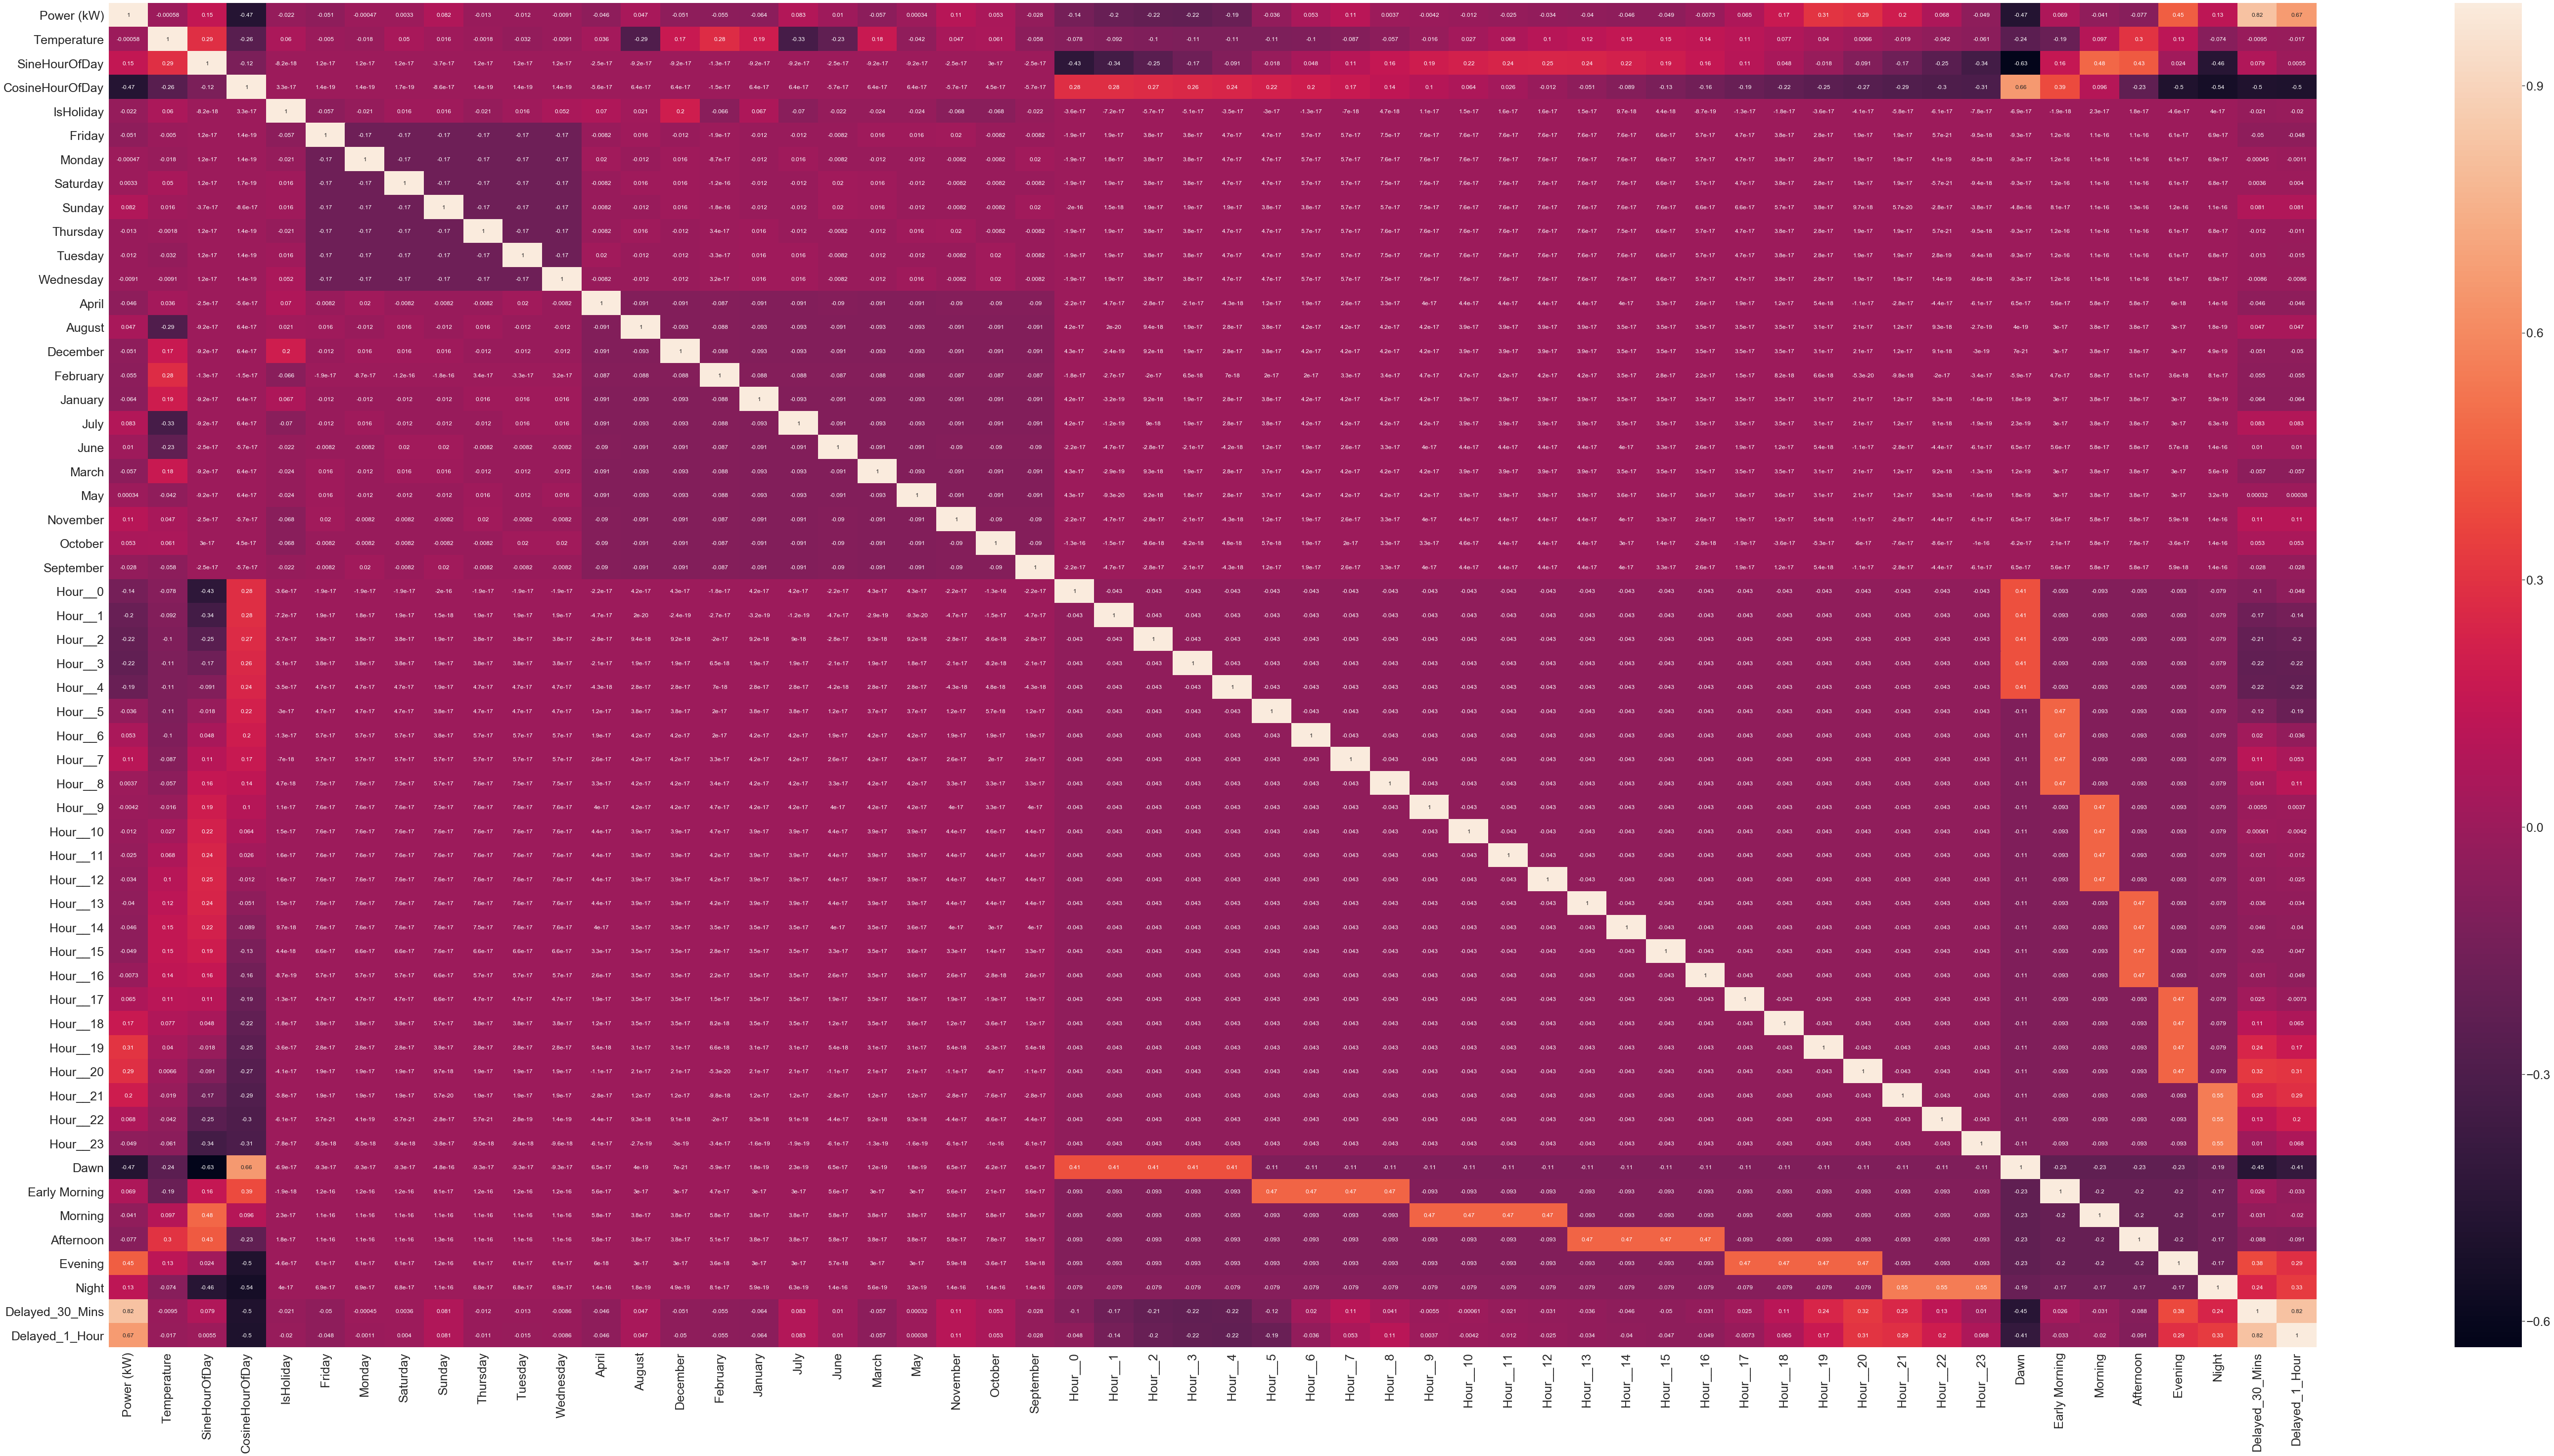

In [ ]:
##Additionally, we can do Correlation based feature selection
sns.heatmap(local_train.corr(), annot=True)

## Model Fitting

In [ ]:
##update dataset with only useful predictors
X = local_train[stepwise_model[1]]
local_test = local_test_[stepwise_model[1]]

X_train = X.iloc[0:1300,:]
X_test = X.iloc[1300:,:]

X_train.head()

Hour__19  Evening  Delayed_30_Mins_Ago  Dawn  Early Morning  Hour__8  \
0         0        0            13.045981     1              0        0   
1         0        0            10.198000     1              0        0   
2         0        0             8.246200     1              0        0   
3         0        0            10.198000     1              0        0   
4         0        0            12.000000     1              0        0   

   Hour__23  Temperature  November  Hour__18  ...  Sunday  October  July  \
0         0    17.736810         0         0  ...       1        1     0   
1         0    17.860000         0         0  ...       1        1     0   
2         0    17.500270         0         0  ...       1        1     0   
3         0    17.960000         0         0  ...       1        1     0   
4         0    17.276532         0         0  ...       1        1     0   

   August  Hour__17  CosineHourOfDay  Friday  May  June  Hour__5  
0       0         0         1.000000       0    0     0        0  
1       0         0         0.991445       0    0     0        0  
2       0         0         0.991445       0    0     0        0  
3       0         0         0.965926       0    0     0        0  
4       0         0         0.965926       0    0     0        0  

[5 rows x 23 columns]

In [ ]:
X_train.shape

(1300, 23)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    return np.sqrt(mse)

### Multiple Linear Regressor - Baseline Model

In [ ]:
## Baseline Model
linear = LinearRegression()
linear.fit(X_train, y_train)
print("R2 Score:", linear.score(X_train, y_train))

##make prediction
y_pred_linear = linear.predict(X_test)


print("MAE:", mean_absolute_error(y_test, y_pred_linear))
print("RMSE:", root_mean_squared_error(y_test, y_pred_linear))

R2 Score: 0.7058012112714949
MAE: 2.5216565186324584
RMSE: 3.227894339184749


### Random Forest Regressor

In [ ]:
randomForest = RandomForestRegressor()
randomForest.fit(X_train, y_train)

print("R2 Score:", randomForest.score(X_train, y_train))

y_pred_rf = randomForest.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", root_mean_squared_error(y_test, y_pred_rf))

R2 Score: 0.9378152533246314
MAE: 2.8881703459683408
RMSE: 3.647256248623122


### Multi Layer Perceptron Regressor

In [ ]:
mlpr = MLPRegressor(hidden_layer_sizes=(100, 120), max_iter=5000, learning_rate_init=0.0001)

mlpr.fit(X_train, y_train)
print("R2 Score:", mlpr.score(X_train, y_train))

y_pred_mlp = mlpr.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_mlp))
print("RMSE:", root_mean_squared_error(y_test, y_pred_mlp))

R2 Score: 0.7182313727591084
MAE: 2.378473526726593
RMSE: 3.1306637458750486


### Decision tree regressor

In [ ]:

decision_tree = DecisionTreeRegressor(max_depth=100, min_samples_leaf=10, criterion='mae')
decision_tree.fit(X_train, y_train)
print("R2 Score: ", decision_tree.score(X_train, y_train))

y_pred_tree = decision_tree.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_tree))
print("RMSE:", root_mean_squared_error(y_test, y_pred_tree))

R2 Score:  0.7078089987807477
MAE: 2.9105216485283205
RMSE: 3.714616334179927


### Xtreme Gradient Boosting Tree

In [ ]:

xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.4, 
                          learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 200)

xgb_regressor.fit(X_train.values, y_train.values)
print("R2 Score", xgb_regressor.score(X_train.values, y_train.values))

y_pred_xgb = xgb_regressor.predict(X_test.values)

print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", root_mean_squared_error(y_test, y_pred_xgb))

R2 Score 0.8626635146605399
MAE: 2.8620161552860157
RMSE: 3.5669610560164973


### Cross Validated Scores using Mean Absolute Error

In [ ]:
## Linear Regression
linear_model = LinearRegression()
score = cross_val_score(linear_model, X, y, cv=tscv, scoring="neg_mean_absolute_error")
print("CV MAE:", np.abs(np.mean(score)))

CV MAE: 2.3155386994793323


In [ ]:
## Random Forest
rfr = RandomForestRegressor(bootstrap = True, max_depth= 90, max_features= 3, min_samples_leaf= 4, min_samples_split= 8, n_estimators= 400)
score = cross_val_score(rfr, X, y, cv=tscv, scoring="neg_mean_absolute_error")
print("CV MAE:", np.abs(np.mean(score)))

CV MAE: 2.4028176602743883


In [ ]:
##Neural Net: MLP
mlpr = MLPRegressor(hidden_layer_sizes=(120,100), max_iter=1000, learning_rate_init=0.0001)
score = cross_val_score(mlpr, X, y, cv=tscv, scoring="neg_mean_absolute_error")
print("CV MAE:", np.abs(np.mean(score)))

CV MAE: 2.3066788513940875


In [ ]:
## Decision Tree
decision_tree = DecisionTreeRegressor()
score = cross_val_score(decision_tree, X, y, cv=tscv, scoring="neg_mean_absolute_error")

print("CV MAE:", np.abs(np.mean(score)))

CV MAE: 3.1987739769917582


In [ ]:
## XGB Regressor
xgb_regressor_basic = xgb.XGBRegressor(objective='reg:squarederror')
score = cross_val_score(xgb_regressor_basic, X, y, cv=tscv, scoring="neg_mean_absolute_error")
print("CV MAE:", np.abs(np.mean(score)))

CV MAE: 2.295467010660106


## Hyperparameter Tuning

In [ ]:
## Best parameters {'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 200}
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200, 300, 400]
}


# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)


# Fit the grid search to the data
grid_search.fit(X, y)
#print(grid_search.best_params_)

best_grid_random_forest = grid_search.best_estimator_
print("R2 Score:", best_grid_random_forest.score(X, y))

score = cross_val_score(best_grid_random_forest, X, y, cv=5, scoring="neg_mean_absolute_error")
print("CV MAE TUNED RANDOM FOREST:", np.abs(np.mean(score)))

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  6.6min finished


R2 Score: 0.7979983645336131
CV MAE TUNED RANDOM FOREST: 2.3852333563624333


In [ ]:
##Just in case you don't have XGB install, you can uncomment and run this command below
#!pip install xgboost

In [ ]:
xgb_parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.1],
              'max_depth': [5,6],
              'subsample': [0.3, 0.6],
              'colsample_bytree': [0.3, 0.4],
              'n_estimators': [100, 200, 300]}

xgb_model = xgb.XGBRegressor()
xgb_grid_search = GridSearchCV(xgb_model, param_grid= xgb_parameters, n_jobs=-1, cv=5, verbose=2)
xgb_grid_search.fit(X.values, y.values)

## Get best estimator and run cross evaluation
best_xgb_estimator = xgb_grid_search.best_estimator_
#print(xgb_grid_search.best_params_)
print("R2 Score:", best_xgb_estimator.score(X.values, y.values))

score = cross_val_score(best_xgb_estimator, X, y, cv=tscv, scoring="neg_mean_absolute_error")
print("CV MAE Tuned XGB:", np.abs(np.mean(score)))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.0min finished


R2 Score: 0.7649509197034012
CV MAE Tuned XGB: 2.3246044508959693


In [ ]:
##Hyper Parameter for MLP Regressor
mlp_parameters = [{'hidden_layer_sizes': [10,20,30,40,50,60],
'activation': ['relu', 'tanh'],
'solver':['lbfgs', 'adam'], 
'alpha':[0.0001],
'batch_size':['auto'], 'learning_rate':['constant'],
'learning_rate_init':[0.0001], 'max_iter':[500, 600,700]}]

mlp_estimator=MLPRegressor()

mlp_grid_search = GridSearchCV(mlp_estimator, n_jobs=-1, param_grid= mlp_parameters, cv=5, verbose=2)
mlp_grid_search.fit(X, y)

## Get best estimator and run cross evaluation
best_mlp_estimator = mlp_grid_search.best_estimator_
#print(xgb_grid_search.best_params_)
print("R2 Score:", best_mlp_estimator.score(X, y))

score = cross_val_score(best_mlp_estimator, X, y, cv=tscv, scoring="neg_mean_absolute_error")
print("CV MAE Tuned MLP:", np.abs(np.mean(score)))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 25.4min finished


R2 Score: 0.7372982316062617
CV MAE Tuned MLP: 2.3071988437490583


### Voting Regressor

In [ ]:
##Finally, we shall make prediction by taking a vote of the three best performing model

voting_regressor = VotingRegressor([('rf', best_grid_random_forest), ('xgb', best_xgb_estimator), ('mlp', best_mlp_estimator)])
voting_regressor.fit(X.values, y.values)

score = cross_val_score(voting_regressor, X, y, cv=tscv, scoring="neg_mean_absolute_error")
print("CV Voting Regressor:", np.abs(np.mean(score)))

CV MAE Tuned MLP: 2.3130232399751685


## Prediction

In [ ]:

predictions = list()
for index, row in local_test.iterrows():
    
    test_data_ = local_test.iloc[index,:].values
    
    ##Update the delay load with the currently predicted value
    if(len(predictions) >= 1):
        test_data_[2] = predictions[-1]

    test_train_ = test_data_.reshape(1,-1)
    
    predictions.append(voting_regressor.predict(test_train_)[0])

##Write submission to a csv file
submission_df = pd.DataFrame({"Datetime": test_df["DateTime"], "Power (kW)": predictions})
submission_df.to_csv('Load_Predictions.csv', index=False)
